In [9]:
# Environment setup taken from tutorial 3 notebook
# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# authenticate
auth.authenticate_user()

# Replace with your project_id
# Set up environment variables
project_id = 'ml-for-health-395112'
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project.')
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
  return pd.io.gbq.read_gbq(
      query,
      project_id=project_id,
      dialect='standard')

# set the dataset
# if you want to use the demo, change this to mimic_demo
dataset = 'mimiciv'

In [ ]:
# Find ICD codes
df = run_query("""
select
  long_title
  ,ic.icd_code
  ,count(subject_id) as count
from `physionet-data.mimiciv_hosp.diagnoses_icd` ic
join
(SELECT * FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses` where long_title like '%hemiplegia%') title
on ic.icd_code = title.icd_code and ic.icd_version = title.icd_version
group by long_title, ic.icd_code
order by count desc
""")
df

,long_title,icd_code,count
0,"Late effects of cerebrovascular disease, hemip...",43820,1312
1,"Late effects of cerebrovascular disease, hemip...",43822,128
2,"Late effects of cerebrovascular disease, hemip...",43821,117
3,Flaccid hemiplegia and hemiparesis affecting u...,34200,93
4,Other specified hemiplegia and hemiparesis aff...,34280,62
5,Flaccid hemiplegia affecting left nondominant ...,G8104,54
6,Flaccid hemiplegia affecting right dominant side,G8101,50
7,Other specified hemiplegia and hemiparesis aff...,34281,45
8,Congenital hemiplegia,3431,37
9,Other specified hemiplegia and hemiparesis aff...,34282,37


Adopted and modified from MIMICIV Sample repository:
https://github.com/MIT-LCP/mimic-iv/blob/master/concepts/comorbidity/charlson.sql

In [ ]:
df= run_query("""SELECT DISTINCT icd_code, icd_version
FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
WHERE
  icd_code in ('25000','25002', '25010','25012','25040','25042','25050','25052', '25060','25062','25070','25072','25090','25092') OR
  icd_code LIKE '%E11%'

LIMIT 1000""")
df

,icd_code,icd_version
0,25072,9
1,25060,9
2,25000,9
3,25002,9
4,25042,9
...,...,...
82,E11341,10
83,E113212,10
84,E113419,10
85,E113553,10


In [48]:
df = run_query("""
WITH DiabeticPatients AS (
SELECT DISTINCT ic.subject_id, ic.hadm_id, ic.admittime, ic.dischtime, p.anchor_age, p.anchor_year, p.gender, p.dod, (p.anchor_age + EXTRACT(YEAR FROM ic.admittime) - p.anchor_year) AS age_at_admission
    FROM `physionet-data.mimiciv_hosp.admissions` AS ic
    JOIN `physionet-data.mimiciv_hosp.patients` AS p ON ic.subject_id = p.subject_id
    WHERE ic.subject_id IN (
        SELECT DISTINCT subject_id
        FROM `physionet-data.mimiciv_hosp.diagnoses_icd` d
        WHERE
          d.icd_code in ('25000','25002', '25010','25012','25040','25042','25050','25052', '25060','25062','25070','25072','25090','25092') OR
          d.icd_code LIKE '%E11%'
    )
)
, Weights AS (
    SELECT DISTINCT subject_id, hadm_id, value as weight
    FROM `physionet-data.mimiciv_icu.chartevents`
    WHERE itemid IN (224639, 226512)
    AND valuenum IS NOT NULL AND valuenum > 0
    ORDER BY subject_id, hadm_id
)

, AverageWeights AS (
    SELECT subject_id, hadm_id, AVG(CAST(weight AS FLOAT64)) as avg_weight
    FROM Weights
    GROUP BY subject_id, hadm_id
)

, Heights AS (
    SELECT DISTINCT subject_id, hadm_id, value as height
    FROM `physionet-data.mimiciv_icu.chartevents`
    WHERE itemid IN (226730)
    AND valuenum IS NOT NULL AND valuenum > 0
    ORDER BY subject_id, hadm_id
)

, AverageHeights AS (
    SELECT subject_id, hadm_id, AVG(CAST(height AS FLOAT64)) as avg_height
    FROM Heights
    GROUP BY subject_id, hadm_id
)



, diag AS
(
    SELECT
        hadm_id
        , CASE WHEN icd_version = 9 THEN icd_code ELSE NULL END AS icd9_code
        , CASE WHEN icd_version = 10 THEN icd_code ELSE NULL END AS icd10_code
    FROM `physionet-data.mimiciv_hosp.diagnoses_icd` diag
    -- WHERE hadm_id IN (SELECT hadm_id FROM DiabeticPatients)
)
, com AS
(
    SELECT
        ad.hadm_id

        -- Myocardial infarction
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('410','412')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('I21','I22')
            OR
            SUBSTR(icd10_code, 1, 4) = 'I252'
            THEN 1
            ELSE 0 END) AS myocardial_infarct

        -- Congestive heart failure
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) = '428'
            OR
            SUBSTR(icd9_code, 1, 5) IN ('39891','40201','40211','40291','40401','40403',
                          '40411','40413','40491','40493')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '4254' AND '4259'
            OR
            SUBSTR(icd10_code, 1, 3) IN ('I43','I50')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('I099','I110','I130','I132','I255','I420',
                                                   'I425','I426','I427','I428','I429','P290')
            THEN 1
            ELSE 0 END) AS congestive_heart_failure

        -- Peripheral vascular disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('440','441')
            OR
            SUBSTR(icd9_code, 1, 4) IN ('0930','4373','4471','5571','5579','V434')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '4431' AND '4439'
            OR
            SUBSTR(icd10_code, 1, 3) IN ('I70','I71')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('I731','I738','I739','I771','I790',
                                                   'I792','K551','K558','K559','Z958','Z959')
            THEN 1
            ELSE 0 END) AS peripheral_vascular_disease

        -- Cerebrovascular disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) BETWEEN '430' AND '438'
            OR
            SUBSTR(icd9_code, 1, 5) = '36234'
            OR
            SUBSTR(icd10_code, 1, 3) IN ('G45','G46')
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'I60' AND 'I69'
            OR
            SUBSTR(icd10_code, 1, 4) = 'H340'
            THEN 1
            ELSE 0 END) AS cerebrovascular_disease

        -- Dementia
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) = '290'
            OR
            SUBSTR(icd9_code, 1, 4) IN ('2941','3312')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('F00','F01','F02','F03','G30')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('F051','G311')
            THEN 1
            ELSE 0 END) AS dementia

        -- Chronic pulmonary disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) BETWEEN '490' AND '505'
            OR
            SUBSTR(icd9_code, 1, 4) IN ('4168','4169','5064','5081','5088')
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'J40' AND 'J47'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'J60' AND 'J67'
            OR
            SUBSTR(icd10_code, 1, 4) IN ('I278','I279','J684','J701','J703')
            THEN 1
            ELSE 0 END) AS chronic_pulmonary_disease

        -- Rheumatic disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) = '725'
            OR
            SUBSTR(icd9_code, 1, 4) IN ('4465','7100','7101','7102','7103',
                                                  '7104','7140','7141','7142','7148')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('M05','M06','M32','M33','M34')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('M315','M351','M353','M360')
            THEN 1
            ELSE 0 END) AS rheumatic_disease

        -- Peptic ulcer disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('531','532','533','534')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('K25','K26','K27','K28')
            THEN 1
            ELSE 0 END) AS peptic_ulcer_disease

        -- Mild liver disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('570','571')
            OR
            SUBSTR(icd9_code, 1, 4) IN ('0706','0709','5733','5734','5738','5739','V427')
            OR
            SUBSTR(icd9_code, 1, 5) IN ('07022','07023','07032','07033','07044','07054')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('B18','K73','K74')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('K700','K701','K702','K703','K709','K713',
                                                   'K714','K715','K717','K760','K762',
                                                   'K763','K764','K768','K769','Z944')
            THEN 1
            ELSE 0 END) AS mild_liver_disease

        -- Diabetes without chronic complication
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 4) IN ('2500','2501','2502','2503','2508','2509')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('E100','E10l','E106','E108','E109','E110','E111',
                                                   'E116','E118','E119','E120','E121','E126','E128',
                                                   'E129','E130','E131','E136','E138','E139','E140',
                                                   'E141','E146','E148','E149')
            THEN 1
            ELSE 0 END) AS diabetes_without_cc

        -- Diabetes with chronic complication
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 4) IN ('2504','2505','2506','2507')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('E102','E103','E104','E105','E107','E112','E113',
                                                   'E114','E115','E117','E122','E123','E124','E125',
                                                   'E127','E132','E133','E134','E135','E137','E142',
                                                   'E143','E144','E145','E147')
            THEN 1
            ELSE 0 END) AS diabetes_with_cc

        -- Hemiplegia or paraplegia
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('342','343')
            OR
            SUBSTR(icd9_code, 1, 4) IN ('3341','3440','3441','3442',
                                                  '3443','3444','3445','3446','3449')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('G81','G82')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('G041','G114','G801','G802','G830',
                                                   'G831','G832','G833','G834','G839')
            THEN 1
            ELSE 0 END) AS paraplegia

        -- Renal disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('582','585','586','V56')
            OR
            SUBSTR(icd9_code, 1, 4) IN ('5880','V420','V451')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '5830' AND '5837'
            OR
            SUBSTR(icd9_code, 1, 5) IN ('40301','40311','40391','40402','40403','40412','40413','40492','40493')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('N18','N19')
            OR
            SUBSTR(icd10_code, 1, 4) IN ('I120','I131','N032','N033','N034',
                                                   'N035','N036','N037','N052','N053',
                                                   'N054','N055','N056','N057','N250',
                                                   'Z490','Z491','Z492','Z940','Z992')
            THEN 1
            ELSE 0 END) AS renal_disease

        -- Any malignancy, including lymphoma and leukemia, except malignant neoplasm of skin
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) BETWEEN '140' AND '172'
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '1740' AND '1958'
            OR
            SUBSTR(icd9_code, 1, 3) BETWEEN '200' AND '208'
            OR
            SUBSTR(icd9_code, 1, 4) = '2386'
            OR
            SUBSTR(icd10_code, 1, 3) IN ('C43','C88')
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C00' AND 'C26'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C30' AND 'C34'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C37' AND 'C41'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C45' AND 'C58'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C60' AND 'C76'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C81' AND 'C85'
            OR
            SUBSTR(icd10_code, 1, 3) BETWEEN 'C90' AND 'C97'
            THEN 1
            ELSE 0 END) AS malignant_cancer

        -- Moderate or severe liver disease
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 4) IN ('4560','4561','4562')
            OR
            SUBSTR(icd9_code, 1, 4) BETWEEN '5722' AND '5728'
            OR
            SUBSTR(icd10_code, 1, 4) IN ('I850','I859','I864','I982','K704','K711',
                                                   'K721','K729','K765','K766','K767')
            THEN 1
            ELSE 0 END) AS severe_liver_disease

        -- Metastatic solid tumor
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('196','197','198','199')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('C77','C78','C79','C80')
            THEN 1
            ELSE 0 END) AS metastatic_solid_tumor

        -- AIDS/HIV
        , MAX(CASE WHEN
            SUBSTR(icd9_code, 1, 3) IN ('042','043','044')
            OR
            SUBSTR(icd10_code, 1, 3) IN ('B20','B21','B22','B24')
            THEN 1
            ELSE 0 END) AS aids
    FROM `physionet-data.mimiciv_hosp.admissions` ad
    LEFT JOIN diag
    ON ad.hadm_id = diag.hadm_id
    GROUP BY ad.hadm_id
)
, ag AS
(
    SELECT
        hadm_id,
        age_at_admission,
        CASE
            WHEN age_at_admission <= 40 THEN 0
            WHEN age_at_admission <= 50 THEN 1
            WHEN age_at_admission <= 60 THEN 2
            WHEN age_at_admission <= 70 THEN 3
            ELSE 4
        END AS age_score
    FROM DiabeticPatients
)
SELECT
    dp.subject_id,
    # le.stay_id,
    # le.los,
    dp.hadm_id,
    dp.gender,
    aw.avg_weight,
    ah.avg_height,
    # w.weight,
    # h.height,
    CASE WHEN dp.dod IS NOT NULL THEN 'Deceased' ELSE 'Alive' END AS death_status,
    (dp.anchor_age + EXTRACT(YEAR FROM dp.admittime) - dp.anchor_year) AS age_at_admission,
    DATE_DIFF(dp.dod, dp.dischtime, DAY) <= 30 AS died_within_30_days,
    DATE_DIFF(dp.dod, dp.dischtime, DAY) <= 90 AS died_within_90_days,
    DATE_DIFF(dp.dod, dp.dischtime, DAY) <= 365 AS died_within_1_year,
    DATE_DIFF(dp.dischtime, dp.admittime, DAY) as days_in_icu

    --ad.subject_id
    --, ad.hadm_id
    # , ag.age_score
    # , myocardial_infarct
    # , congestive_heart_failure
    # , peripheral_vascular_disease
    # , cerebrovascular_disease
    # , dementia
    # , chronic_pulmonary_disease
    # , rheumatic_disease
    # , peptic_ulcer_disease
    # , mild_liver_disease
    # , diabetes_without_cc
    # , diabetes_with_cc
    # , paraplegia
    # , renal_disease
    # , malignant_cancer
    # , severe_liver_disease
    # , metastatic_solid_tumor
    # , aids
    -- Calculate the Charlson Comorbidity Score using the original
    -- weights from Charlson, 1987.
    , age_score
    + myocardial_infarct + congestive_heart_failure + peripheral_vascular_disease
    + cerebrovascular_disease + dementia + chronic_pulmonary_disease
    + rheumatic_disease + peptic_ulcer_disease
    + GREATEST(mild_liver_disease, 3*severe_liver_disease)
    + GREATEST(2*diabetes_with_cc, diabetes_without_cc)
    + GREATEST(2*malignant_cancer, 6*metastatic_solid_tumor)
    + 2*paraplegia + 2*renal_disease
    + 6*aids
    AS charlson_comorbidity_index

# FROM DiabeticPatients dp
# INNER JOIN `physionet-data.mimiciv_icu.icustays` le ON dp.subject_id = le.subject_id AND dp.hadm_id = le.hadm_id
# LEFT JOIN com ON dp.hadm_id = com.hadm_id
# LEFT JOIN ag ON com.hadm_id = ag.hadm_id
# LEFT JOIN AverageWeights aw ON dp.subject_id = aw.subject_id AND dp.hadm_id = aw.hadm_id
# LEFT JOIN AverageHeights ah ON dp.subject_id = ah.subject_id AND dp.hadm_id = ah.hadm_id
# JOIN `physionet-data.mimiciv_hosp.patients` p ON dp.subject_id = p.subject_id
# # WHERE aw.avg_weight IS NOT NULL AND ah.avg_height IS NOT NULL
# ORDER BY dp.subject_id, le.hadm_id, le.stay_id;
FROM DiabeticPatients dp
# INNER JOIN `physionet-data.mimiciv_icu.icustays` le ON dp.subject_id = le.subject_id
LEFT JOIN com ON dp.hadm_id = com.hadm_id
LEFT JOIN ag ON com.hadm_id = ag.hadm_id
LEFT JOIN AverageWeights aw ON dp.subject_id = aw.subject_id AND dp.hadm_id = aw.hadm_id
LEFT JOIN AverageHeights ah ON dp.subject_id = ah.subject_id AND dp.hadm_id = ah.hadm_id
# LEFT JOIN Weights w ON dp.subject_id = w.subject_id AND dp.hadm_id = w.hadm_id
# LEFT JOIN Heights h ON dp.subject_id = h.subject_id AND dp.hadm_id = h.hadm_id
JOIN `physionet-data.mimiciv_hosp.patients` p ON dp.subject_id = p.subject_id
WHERE aw.avg_weight IS NOT NULL AND ah.avg_height IS NOT NULL
# w.weight IS NOT NULL AND h.height IS NOT NULL
ORDER BY dp.subject_id, dp.hadm_id;
""")

In [49]:
df

,subject_id,hadm_id,gender,avg_weight,avg_height,death_status,age_at_admission,died_within_30_days,died_within_90_days,died_within_1_year,days_in_icu,charlson_comorbidity_index
0,10002013,23581541,F,100.050000,157.0,Alive,57,<NA>,<NA>,<NA>,5,8
1,10002443,21329021,M,154.850000,178.0,Alive,53,<NA>,<NA>,<NA>,3,4
2,10002495,24982426,M,64.175000,170.0,Alive,81,<NA>,<NA>,<NA>,7,7
3,10005817,20626031,M,93.050000,173.0,Deceased,66,False,False,False,8,8
4,10005817,28661809,M,88.185714,175.0,Deceased,69,True,True,True,16,8
...,...,...,...,...,...,...,...,...,...,...,...,...
11062,19997293,28847872,M,107.300000,183.0,Deceased,76,False,True,True,12,11
11063,19997473,27787494,F,63.700000,157.0,Alive,82,<NA>,<NA>,<NA>,21,9
11064,19998878,26489544,M,90.000000,183.0,Deceased,56,False,False,True,2,6
11065,19999287,20175828,F,88.533333,165.0,Deceased,77,True,True,True,15,8


# Loading from Ray's file

In [50]:
# Read the CSV file
df = pd.read_csv('mortality.csv')

# Display the first few rows of the DataFrame
df.head()

,Unnamed: 0,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,...,avg_height,death_status,age_at_admission,died_within_30_days,died_within_90_days,died_within_1_year,days_in_icu,charlson_comorbidity_index,gender_F,gender_M
0,0,10000980,26913865,39765666,2189-06-27 08:54:00,77.0,150.0,77.0,92.0,150.0,...,NaN,Deceased,76,False,False,False,6,9,True,False
1,1,10002013,23581541,39060235,2160-05-18 10:26:00,80.0,134.0,75.0,94.0,104.0,...,157.0,Alive,57,False,NaN,NaN,5,8,True,False
2,2,10002443,21329021,35044219,2183-10-18 00:50:00,81.0,136.0,81.0,99.0,136.0,...,178.0,Alive,53,False,NaN,NaN,3,4,False,True
3,3,10002495,24982426,36753294,2141-05-22 20:23:00,115.0,160.0,78.0,94.0,160.0,...,170.0,Alive,81,False,NaN,NaN,7,7,False,True
4,4,10005817,20626031,32604416,2132-12-15 10:58:00,80.0,126.0,51.0,74.0,NaN,...,173.0,Deceased,66,False,False,False,8,8,False,True


In [51]:
df.describe()


,Unnamed: 0,subject_id,hadm_id,stay_id,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,...,resp_rate,temperature,spo2,glucose,los,avg_weight,avg_height,age_at_admission,days_in_icu,charlson_comorbidity_index
count,15422.000000,1.542200e+04,1.542200e+04,1.542200e+04,15413.000000,15337.000000,15337.000000,15387.000000,14082.000000,14081.000000,...,15398.000000,14984.000000,15396.000000,15196.000000,15422.000000,15411.000000,8299.000000,15422.000000,15422.000000,15422.000000
mean,7710.500000,1.496731e+07,2.498386e+07,3.496874e+07,88.271459,125.686249,67.923257,83.674530,125.309118,68.963568,...,19.448532,36.734184,96.975773,185.199322,3.517653,88.584240,169.065004,67.213656,12.367527,7.270717
std,4452.092261,2.858611e+06,2.881410e+06,2.889960e+06,19.834355,26.027201,18.309305,18.837275,26.183387,18.567617,...,6.019288,0.709607,3.735889,123.932839,4.955251,27.275021,13.742510,13.270538,15.037598,2.787048
min,0.000000,1.000098e+07,2.000009e+07,3.000021e+07,24.000000,26.000000,10.000000,1.000000,26.000000,10.000000,...,2.000000,26.670000,21.000000,11.000000,0.003519,1.000000,11.000000,18.000000,0.000000,0.000000
25%,3855.250000,1.252242e+07,2.247452e+07,3.247655e+07,75.000000,107.000000,55.000000,71.000000,106.000000,56.000000,...,15.000000,36.440000,95.000000,124.000000,1.128278,71.100000,163.000000,59.000000,5.000000,5.000000
50%,7710.500000,1.492769e+07,2.500032e+07,3.492727e+07,86.000000,124.000000,66.000000,82.000000,123.000000,67.000000,...,18.000000,36.720000,98.000000,163.000000,2.002054,85.000000,170.000000,68.000000,8.000000,7.000000
75%,11565.750000,1.742979e+07,2.747066e+07,3.745374e+07,100.000000,142.000000,78.000000,94.000000,142.000000,80.000000,...,23.000000,37.000000,100.000000,219.000000,3.806270,101.400000,178.000000,77.000000,14.000000,9.000000
max,15421.000000,1.999983e+07,2.999962e+07,3.999862e+07,247.000000,259.000000,190.000000,257.000000,259.000000,190.000000,...,69.000000,41.200000,100.000000,9999.000000,103.499005,1120.000000,439.000000,100.000000,296.000000,20.000000


In [52]:
from sklearn.preprocessing import MinMaxScaler

# # Replace NaN values in avg_weight and avg_height with their respective means
# df['avg_weight'].fillna(df['avg_weight'].mean(), inplace=True)
# df['avg_height'].fillna(df['avg_height'].mean(), inplace=True)

# # Replace NaN values in died_within columns with False
# columns_to_update = ['died_within_30_days', 'died_within_90_days', 'died_within_1_year']
# for col in columns_to_update:
#     df[col].fillna(False, inplace=True)

# # Adding BMI Column
# df['bmi'] = df['avg_weight'] / (df['avg_height'] / 100)**2

# # Replace gender values: 'M' with 1 and 'F' with 0
# df['gender_F'] = df['gender_F'].astype(str).str.strip().replace({'True': 1, 'False': 0})
# df['gender_M'] = df['gender_M'].astype(str).str.strip().replace({'True': 1, 'False': 0})

# # Replace death_status values: 'Deceased' with 1 and 'Alive' with 0
# df['death_status'] = df['death_status'].replace({'Deceased': 1, 'Alive': 0})


# df['glucose'].fillna(df['glucose'].mean(), inplace=True)

# df['mbp'].fillna(df['mbp'].mean(), inplace=True)


# # Columns to normalize
# cols_to_normalize = ['los', 'avg_weight', 'avg_height', 'age_at_admission', 'days_in_icu', 'charlson_comorbidity_index', 'bmi', 'mbp']

# # Instantiate the scaler
# scaler = MinMaxScaler()

# # Fit the scaler to the data and transform the columns
# df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])


# for col in columns_to_update:
#     df[col] = df[col].astype(str).str.strip().replace({'True': 1, 'False': 0, '<NA>': np.nan})
# weight, height, died_within_days, bmi, gender, death_status, glucose

# Replace NaN values in avg_weight and avg_height with their respective means
features_fill_nan = ['avg_weight', 'avg_height', 'glucose','heart_rate','sbp','dbp','mbp','sbp_ni','dbp_ni','mbp_ni','resp_rate','temperature','spo2','glucose','los']
for col in features_fill_nan:
    df[col].fillna(df[col].median(), inplace=True)

# Replace NaN values in died_within columns with False
columns_to_update = ['died_within_30_days', 'died_within_90_days', 'died_within_1_year']
for col in columns_to_update:
    df[col].fillna(False, inplace=True)

# Adding BMI Column
df['bmi'] = df['avg_weight'] / (df['avg_height'] / 100)**2

# Replace gender values: 'M' with 1 and 'F' with 0
df['gender_F'] = df['gender_F'].astype(str).str.strip().replace({'True': 1, 'False': 0})
df.drop(labels='gender_M',axis=1,inplace=True)

# Replace death_status values: 'Deceased' with 1 and 'Alive' with 0
df['death_status'] = df['death_status'].replace({'Deceased': 1, 'Alive': 0})

# Columns to normalize
cols_to_normalize = ['glucose','heart_rate','sbp','dbp','mbp','sbp_ni','dbp_ni','mbp_ni','resp_rate','temperature','spo2','los', 'avg_weight', 'avg_height', 'age_at_admission', 'days_in_icu', 'charlson_comorbidity_index', 'bmi']

# Instantiate the scaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the columns
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])


for col in columns_to_update:
    df[col] = df[col].astype(str).str.strip().replace({'True': 1, 'False': 0, '<NA>': np.nan})

# df.drop(columns=['hadm_id','subject_id', 'stay_id','Unnamed: 0','charttime'], axis=1, inplace=True)
df.drop(columns=['hadm_id','subject_id', 'stay_id','Unnamed: 0','charttime', 'avg_weight', 'avg_height','sbp_ni','dbp_ni','mbp_ni','death_status'], axis=1, inplace=True)
df.describe()


df

,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2,glucose,los,age_at_admission,died_within_30_days,died_within_90_days,died_within_1_year,days_in_icu,charlson_comorbidity_index,gender_F,bmi
0,0.237668,0.532189,0.372222,0.355469,0.313433,0.688231,1.000000,0.009912,0.004773,0.707317,0,0,0,0.020270,0.45,1,0.002789
1,0.251121,0.463519,0.361111,0.363281,0.179104,0.724708,1.000000,0.020525,0.012666,0.475610,0,0,0,0.016892,0.40,1,0.004313
2,0.255605,0.472103,0.394444,0.382812,0.313433,0.637990,0.924051,0.021526,0.026544,0.426829,0,0,0,0.010135,0.20,0,0.005201
3,0.408072,0.575107,0.377778,0.363281,0.358209,0.715072,0.924051,0.025330,0.049123,0.768293,0,0,0,0.023649,0.35,0,0.002343
4,0.251121,0.429185,0.227778,0.285156,0.223881,0.655884,1.000000,0.020324,0.022760,0.585366,0,0,0,0.027027,0.40,0,0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15417,0.197309,0.369099,0.433333,0.359375,0.283582,0.690296,0.962025,0.012515,0.044864,0.780488,0,0,0,0.070946,0.45,1,0.002732
15418,0.282511,0.381974,0.333333,0.312500,0.238806,0.695802,0.974684,0.013016,0.035173,0.780488,0,0,0,0.070946,0.45,1,0.002732
15419,0.264574,0.386266,0.372222,0.332031,0.253731,0.703372,1.000000,0.029435,0.007133,0.463415,0,0,1,0.006757,0.30,0,0.002843
15420,0.412556,0.557940,0.344444,0.355469,0.164179,0.726084,1.000000,0.024229,0.005126,0.463415,0,0,1,0.020270,0.30,0,0.003426


In [ ]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score, classification_report

# # Aggregate data at hadm_id level since there are multiple stay_ids per hadm_id
# agg_funcs = {
#     'los': 'sum',
#     'gender_M': 'first',
#     'gender_F': 'first',
#     'avg_weight': 'mean',
#     'avg_height': 'mean',
#     'mbp': 'mean',
#     'age_at_admission': 'first',
#     # 'days_in_icu': 'first',
#     'charlson_comorbidity_index': 'first',
#     'bmi': 'mean',
#     'died_within_30_days': 'max',
#     'died_within_90_days': 'max',
#     'died_within_1_year': 'max',
#     'glucose': 'mean'
# }
# df_agg = df.groupby('hadm_id').agg(agg_funcs).reset_index()

# # Define predictors and target
# X = df_agg.drop(columns=['subject_id','hadm_id', 'died_within_30_days', 'died_within_90_days', 'died_within_1_year'])
# y_30 = df_agg['died_within_30_days']
# y_90 = df_agg['died_within_90_days']
# y_year = df_agg['died_within_1_year']

# # Split data into training and test sets
# X_train, X_test, y_30_train, y_30_test = train_test_split(X, y_30, test_size=0.2, random_state=42)
# _, _, y_90_train, y_90_test = train_test_split(X, y_90, test_size=0.2, random_state=42)
# _, _, y_year_train, y_year_test = train_test_split(X, y_year, test_size=0.2, random_state=42)



In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define predictors and target
X = df.drop(columns=['died_within_30_days', 'died_within_90_days', 'died_within_1_year'])
y_30 = df['died_within_30_days']
y_90 = df['died_within_90_days']
y_year = df['died_within_1_year']

# Split data into training and test sets
X_train, X_test, y_30_train, y_30_test = train_test_split(X, y_30, test_size=0.2, random_state=42)
_, _, y_90_train, y_90_test = train_test_split(X, y_90, test_size=0.2, random_state=42)
_, _, y_year_train, y_year_test = train_test_split(X, y_year, test_size=0.2, random_state=42)

# Train a RandomForest classifier for each time frame
# max_depth 10 performs not well, 100 performs best
# n_estimator 100 performs best - 0.16, 50 and 500 both 0.14

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Predicting Death within 30 Days

# Dummy Model
y_30_pred_baseline = np.zeros(len(y_30_test))

# Random Forest
clf_30 = RandomForestClassifier().fit(X_train, y_30_train)
y_30_pred = clf_30.predict(X_test)

# Logistic Regression
clf_30_logreg = LogisticRegression(max_iter=1000).fit(X_train, y_30_train)
y_30_pred_logreg = clf_30_logreg.predict(X_test)

# SVM (with radial basis function kernel)
clf_30_svm = SVC(kernel='rbf').fit(X_train, y_30_train)
y_30_pred_svm = clf_30_svm.predict(X_test)

# K-Nearest Neighbors (using 3 neighbors)
clf_30_knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_30_train)
y_30_pred_knn = clf_30_knn.predict(X_test)

# Gradient Boosting Classifier
clf_30_gb = GradientBoostingClassifier().fit(X_train, y_30_train)
y_30_pred_gb = clf_30_gb.predict(X_test)

# Predicting Death within 90 Days
# Dummy Model
y_90_pred_baseline = np.zeros(len(y_90_test))

# Random Forest
clf_90 = RandomForestClassifier().fit(X_train, y_90_train)
y_90_pred = clf_90.predict(X_test)


# Logistic Regression
clf_90_logreg = LogisticRegression(max_iter=1000).fit(X_train, y_90_train)
y_90_pred_logreg = clf_90_logreg.predict(X_test)

# SVM (with radial basis function kernel)
clf_90_svm = SVC(kernel='rbf').fit(X_train, y_90_train)
y_90_pred_svm = clf_90_svm.predict(X_test)

# K-Nearest Neighbors
clf_90_knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_90_train)
y_90_pred_knn = clf_90_knn.predict(X_test)

# Gradient Boosting Classifier
clf_90_gb = GradientBoostingClassifier().fit(X_train, y_90_train)
y_90_pred_gb = clf_90_gb.predict(X_test)

# Predicting Death within 1 Year
# Dummy Model
y_year_pred_baseline = np.zeros(len(y_year_test))

# Random Forest
clf_year = RandomForestClassifier().fit(X_train, y_year_train)
y_year_pred = clf_year.predict(X_test)

# Logistic Regression
clf_1y_logreg = LogisticRegression(max_iter=1000).fit(X_train, y_year_train)
y_1y_pred_logreg = clf_1y_logreg.predict(X_test)

# SVM (with radial basis function kernel)
clf_1y_svm = SVC(kernel='rbf').fit(X_train, y_year_train)
y_1y_pred_svm = clf_1y_svm.predict(X_test)

# K-Nearest Neighbors
clf_1y_knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_year_train)
y_1y_pred_knn = clf_1y_knn.predict(X_test)

# Gradient Boosting Classifier
clf_1y_gb = GradientBoostingClassifier().fit(X_train, y_year_train)
y_1y_pred_gb = clf_1y_gb.predict(X_test)

# Evaluate the models
print("Dummy Model - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred))
print(classification_report(y_30_test, y_30_pred))

print("Random Forest - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred))
print(classification_report(y_30_test, y_30_pred))

print("Logistic Regression - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_logreg))
print(classification_report(y_30_test, y_30_pred_logreg))

print("SVM - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_svm))
print(classification_report(y_30_test, y_30_pred_svm))

print("KNN - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_knn))
print(classification_report(y_30_test, y_30_pred_knn))

print("Gradient Boosting - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_gb))
print(classification_report(y_30_test, y_30_pred_gb))

# Evaluating 90 days prediction models
print("Random Forest - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred))
print(classification_report(y_90_test, y_90_pred))

print("Logistic Regression - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_logreg))
print(classification_report(y_90_test, y_90_pred_logreg))

print("SVM - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_svm))
print(classification_report(y_90_test, y_90_pred_svm))

print("KNN - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_knn))
print(classification_report(y_90_test, y_90_pred_knn))

print("Gradient Boosting - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_gb))
print(classification_report(y_90_test, y_90_pred_gb))

# Evaluating 1 year prediction models
print("Random Forest - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_year_pred))
print(classification_report(y_year_test, y_year_pred))

print("Logistic Regression - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_logreg))
print(classification_report(y_year_test, y_1y_pred_logreg))

print("SVM - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_svm))
print(classification_report(y_year_test, y_1y_pred_svm))

print("KNN - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_knn))
print(classification_report(y_year_test, y_1y_pred_knn))

print("Gradient Boosting - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_gb))
print(classification_report(y_year_test, y_1y_pred_gb))



Dummy Model - 30 Days Prediction:
0.8774716369529983
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2655
           1       0.82      0.15      0.26       430

    accuracy                           0.88      3085
   macro avg       0.85      0.57      0.60      3085
weighted avg       0.87      0.88      0.84      3085

Random Forest - 30 Days Prediction:
0.8774716369529983
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2655
           1       0.82      0.15      0.26       430

    accuracy                           0.88      3085
   macro avg       0.85      0.57      0.60      3085
weighted avg       0.87      0.88      0.84      3085

Logistic Regression - 30 Days Prediction:
0.8632090761750405
              precision    recall  f1-score   support

           0       0.87      0.99      0.93      2655
           1       0.56      0.08      0.15       430

    accuracy 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

# Using smote to balance dataset before training

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_30_smote, y_30_smote = smote.fit_resample(X_train, y_30_train)
X_90_smote, y_90_smote = smote.fit_resample(X_train, y_90_train)
X_year_smote, y_year_smote = smote.fit_resample(X_train, y_year_train)

# Train RFC models with balanced data
clf_30 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_90 = RandomForestClassifier(random_state=42, class_weight='balanced')
clf_year = RandomForestClassifier(random_state=42, class_weight='balanced')

clf_30.fit(X_30_smote, y_30_smote)
clf_90.fit(X_90_smote, y_90_smote)
clf_year.fit(X_year_smote, y_year_smote)


# Train Logistic Regression with balanced data
clf_30_logreg = LogisticRegression(max_iter=1000, class_weight='balanced').fit(X_30_smote, y_30_smote)
clf_90_logreg = LogisticRegression(max_iter=1000, class_weight='balanced').fit(X_90_smote, y_90_smote)
clf_1y_logreg = LogisticRegression(max_iter=1000, class_weight='balanced').fit(X_year_smote, y_year_smote)

# Train SVM with balanced data
clf_30_svm = SVC(kernel='rbf', class_weight='balanced').fit(X_30_smote, y_30_smote)
clf_90_svm = SVC(kernel='rbf', class_weight='balanced').fit(X_90_smote, y_90_smote)
clf_1y_svm = SVC(kernel='rbf', class_weight='balanced').fit(X_year_smote, y_year_smote)

# Train K-Nearest Neighbors with balanced data
clf_30_knn = KNeighborsClassifier(n_neighbors=3).fit(X_30_smote, y_30_smote)
clf_90_knn = KNeighborsClassifier(n_neighbors=3).fit(X_90_smote, y_90_smote)
clf_1y_knn = KNeighborsClassifier(n_neighbors=3).fit(X_year_smote, y_year_smote)

# Train Gradient Boosting Classifier with balanced data
clf_30_gb = GradientBoostingClassifier().fit(X_30_smote, y_30_smote)
clf_90_gb = GradientBoostingClassifier().fit(X_90_smote, y_90_smote)
clf_1y_gb = GradientBoostingClassifier().fit(X_year_smote, y_year_smote)

# Predictions
y_30_pred = clf_30.predict(X_test)
y_90_pred = clf_90.predict(X_test)
y_year_pred = clf_year.predict(X_test)

y_30_pred_logreg = clf_30_logreg.predict(X_test)
y_90_pred_logreg = clf_90_logreg.predict(X_test)
y_1y_pred_logreg = clf_1y_logreg.predict(X_test)

y_30_pred_svm = clf_30_svm.predict(X_test)
y_90_pred_svm = clf_90_svm.predict(X_test)
y_1y_pred_svm = clf_1y_svm.predict(X_test)

y_30_pred_knn = clf_30_knn.predict(X_test)
y_90_pred_knn = clf_90_knn.predict(X_test)
y_1y_pred_knn = clf_1y_knn.predict(X_test)

y_30_pred_gb = clf_30_gb.predict(X_test)
y_90_pred_gb = clf_90_gb.predict(X_test)
y_1y_pred_gb = clf_1y_gb.predict(X_test)

# Evaluate models
print("Random Forest - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred))
print(classification_report(y_30_test, y_30_pred))
# print("Mean Squared Error:", mean_squared_error(y_30_test, y_30_pred))
# print("R2 Score:", r2_score(y_30_test, y_30_pred))

print("Logistic Regression - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_logreg))
print(classification_report(y_30_test, y_30_pred_logreg))

print("SVM - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_svm))
print(classification_report(y_30_test, y_30_pred_svm))

print("KNN - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_knn))
print(classification_report(y_30_test, y_30_pred_knn))

print("Gradient Boosting - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_gb))
print(classification_report(y_30_test, y_30_pred_gb))

# Evaluating 90 days prediction models
print("Random Forest - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred))
print(classification_report(y_90_test, y_90_pred))
# print("Mean Squared Error:", mean_squared_error(y_90_test, y_90_pred))
# print("R2 Score:", r2_score(y_90_test, y_90_pred))

print("Logistic Regression - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_logreg))
print(classification_report(y_90_test, y_90_pred_logreg))

print("SVM - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_svm))
print(classification_report(y_90_test, y_90_pred_svm))

print("KNN - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_knn))
print(classification_report(y_90_test, y_90_pred_knn))

print("Gradient Boosting - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_gb))
print(classification_report(y_90_test, y_90_pred_gb))

# Evaluating 1 year prediction models
print("Random Forest - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_year_pred))
print(classification_report(y_year_test, y_year_pred))
# print("Mean Squared Error:", mean_squared_error(y_year_test, y_year_pred))
# print("R2 Score:", r2_score(y_year_test, y_year_pred))

print("Logistic Regression - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_logreg))
print(classification_report(y_year_test, y_1y_pred_logreg))

print("SVM - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_svm))
print(classification_report(y_year_test, y_1y_pred_svm))

print("KNN - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_knn))
print(classification_report(y_year_test, y_1y_pred_knn))

print("Gradient Boosting - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_gb))
print(classification_report(y_year_test, y_1y_pred_gb))

Random Forest - 30 Days Prediction:
0.8411669367909238
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      2655
           1       0.43      0.40      0.41       430

    accuracy                           0.84      3085
   macro avg       0.66      0.66      0.66      3085
weighted avg       0.84      0.84      0.84      3085

Logistic Regression - 30 Days Prediction:
0.7111831442463533
              precision    recall  f1-score   support

           0       0.94      0.71      0.81      2655
           1       0.29      0.74      0.42       430

    accuracy                           0.71      3085
   macro avg       0.62      0.73      0.61      3085
weighted avg       0.85      0.71      0.75      3085

SVM - 30 Days Prediction:
0.6833063209076176
              precision    recall  f1-score   support

           0       0.95      0.67      0.78      2655
           1       0.27      0.76      0.40       430

    accuracy         

In [ ]:
df2 = run_query("""
SELECT
  SubQuery.*,
  CASE WHEN le.itemid = 50809 THEN le.valuenum END AS glucose,
  CASE WHEN le.itemid = 50852 THEN le.valuenum END AS HemoglobinA1c,
  CASE WHEN le.itemid = 50822 THEN le.valuenum END AS potassium,
  CASE WHEN le.itemid = 50824 THEN le.valuenum END AS sodium,
  CASE WHEN le.itemid = 50086 THEN le.valuenum END AS Chloride,
  CASE WHEN le.itemid = 52024 THEN le.valuenum END AS Creatinine,
  CASE WHEN le.itemid = 52647 THEN le.valuenum END AS Urea_Nitrogen,
  CASE WHEN le.itemid = 50861 THEN le.valuenum END AS ALT,
  CASE WHEN le.itemid = 50878 THEN le.valuenum END AS AST
FROM (
  WITH DiabeticPatients AS (
      SELECT DISTINCT subject_id, hadm_id
      FROM `physionet-data.mimiciv_hosp.diagnoses_icd`
      WHERE
        icd_code in ('25000','25002', '25010','25012','25040','25042','25050','25052', '25060','25062','25070','25072','25090','25092') OR
        icd_code LIKE '%E11%'
  )

  SELECT
    dp.subject_id, le.hadm_id, le.stay_id, le.los
  FROM DiabeticPatients dp
  INNER JOIN `physionet-data.mimiciv_icu.icustays` le ON dp.subject_id = le.subject_id AND dp.hadm_id = le.hadm_id
) AS SubQuery
LEFT JOIN `physionet-data.mimiciv_hosp.labevents` le ON SubQuery.subject_id = le.subject_id AND SubQuery.hadm_id = le.hadm_id
WHERE le.itemid IN (50809, 50852, 50822, 50824, 50086, 52024, 52647, 50861, 50878)
ORDER BY SubQuery.subject_id, SubQuery.hadm_id, SubQuery.stay_id
""")
grouped_df = df2.groupby(['subject_id','hadm_id','stay_id']).first().reset_index()
grouped_df

,subject_id,hadm_id,stay_id,los,glucose,HemoglobinA1c,potassium,sodium,Chloride,Creatinine,Urea_Nitrogen,ALT,AST
0,10000980,26913865,39765666,0.497535,NaN,6.8,NaN,NaN,NaN,NaN,NaN,12.0,21.0
1,10002013,23581541,39060235,1.314352,149.0,NaN,4.0,137.0,NaN,NaN,NaN,NaN,NaN
2,10002443,21329021,35044219,2.750729,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0,27.0
3,10002495,24982426,36753294,5.087512,244.0,5.9,NaN,NaN,NaN,NaN,NaN,44.0,210.0
4,10005817,20626031,32604416,2.359097,134.0,7.5,4.0,133.0,NaN,NaN,NaN,40.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16511,19997473,27787494,32568753,3.643750,NaN,6.5,NaN,NaN,NaN,NaN,NaN,107.0,171.0
16512,19998878,26489544,34403689,0.741794,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,71.0
16513,19998878,29356037,30532790,0.534005,223.0,7.0,3.1,139.0,NaN,NaN,NaN,46.0,102.0
16514,19999287,20175828,35165301,4.705752,109.0,NaN,3.8,137.0,NaN,NaN,NaN,NaN,NaN


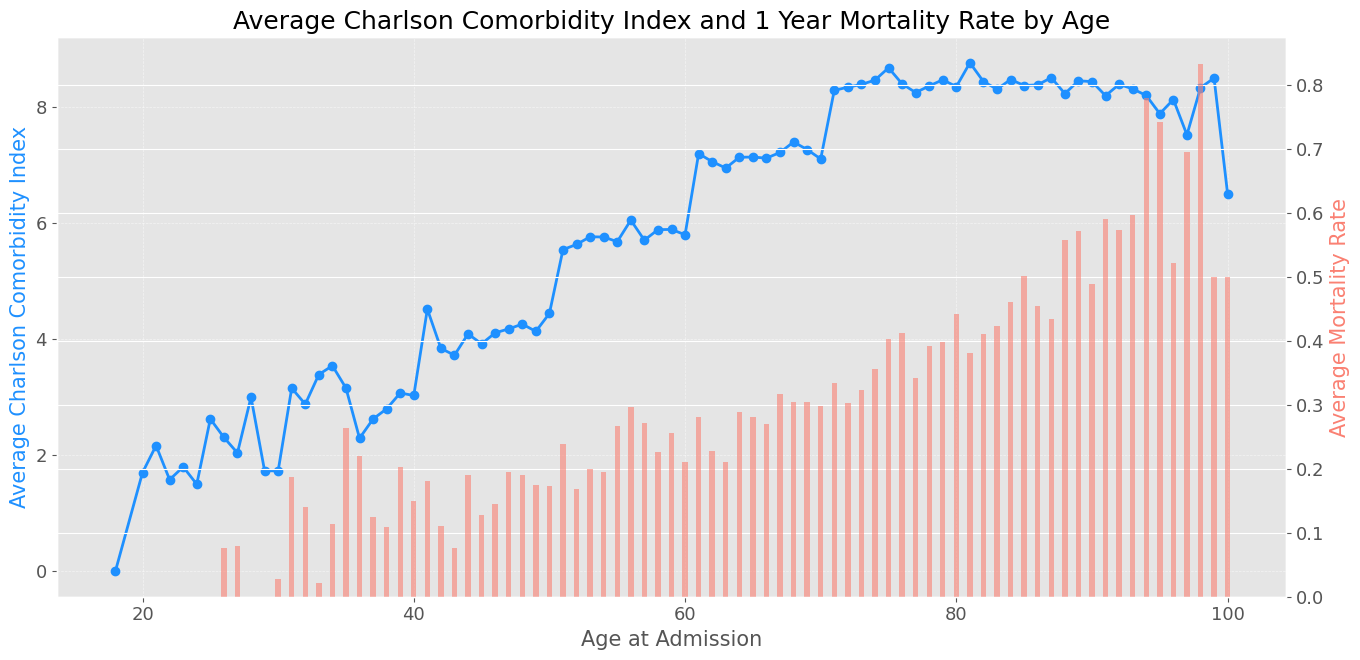

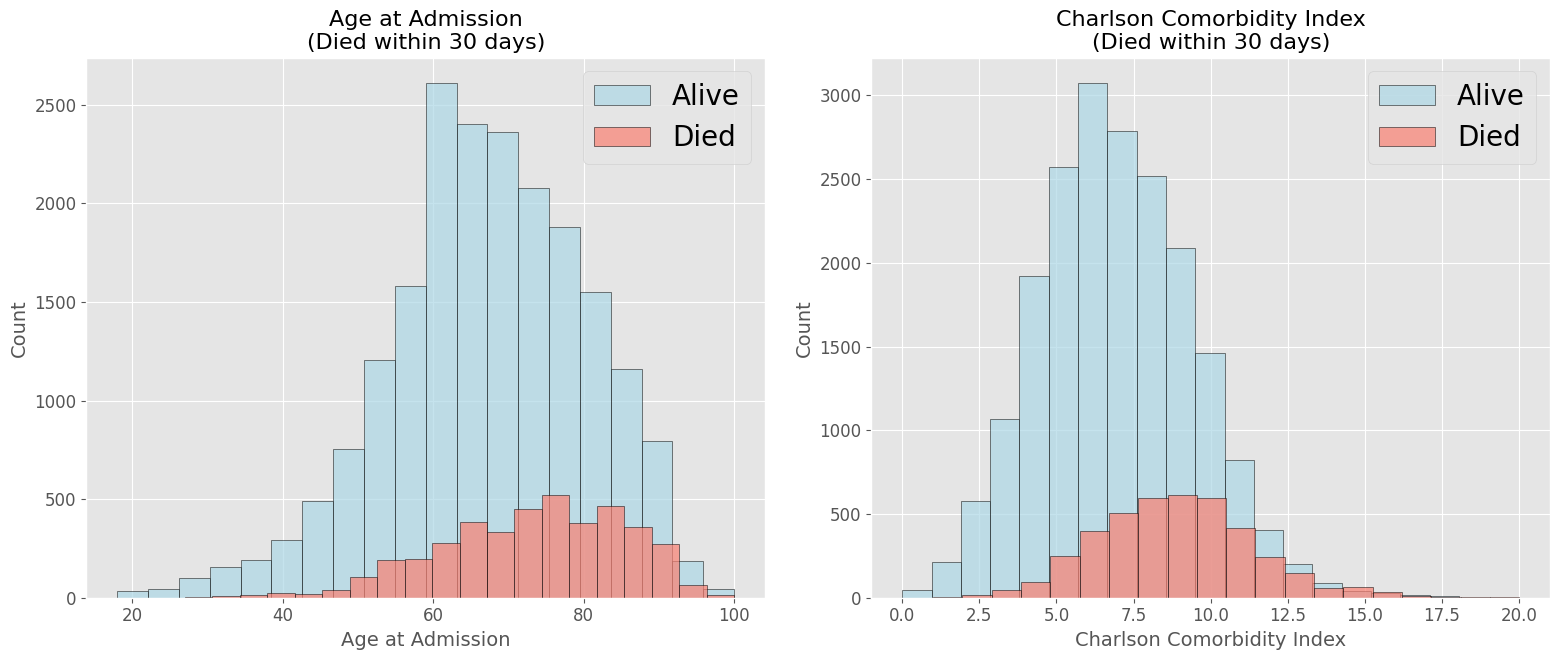

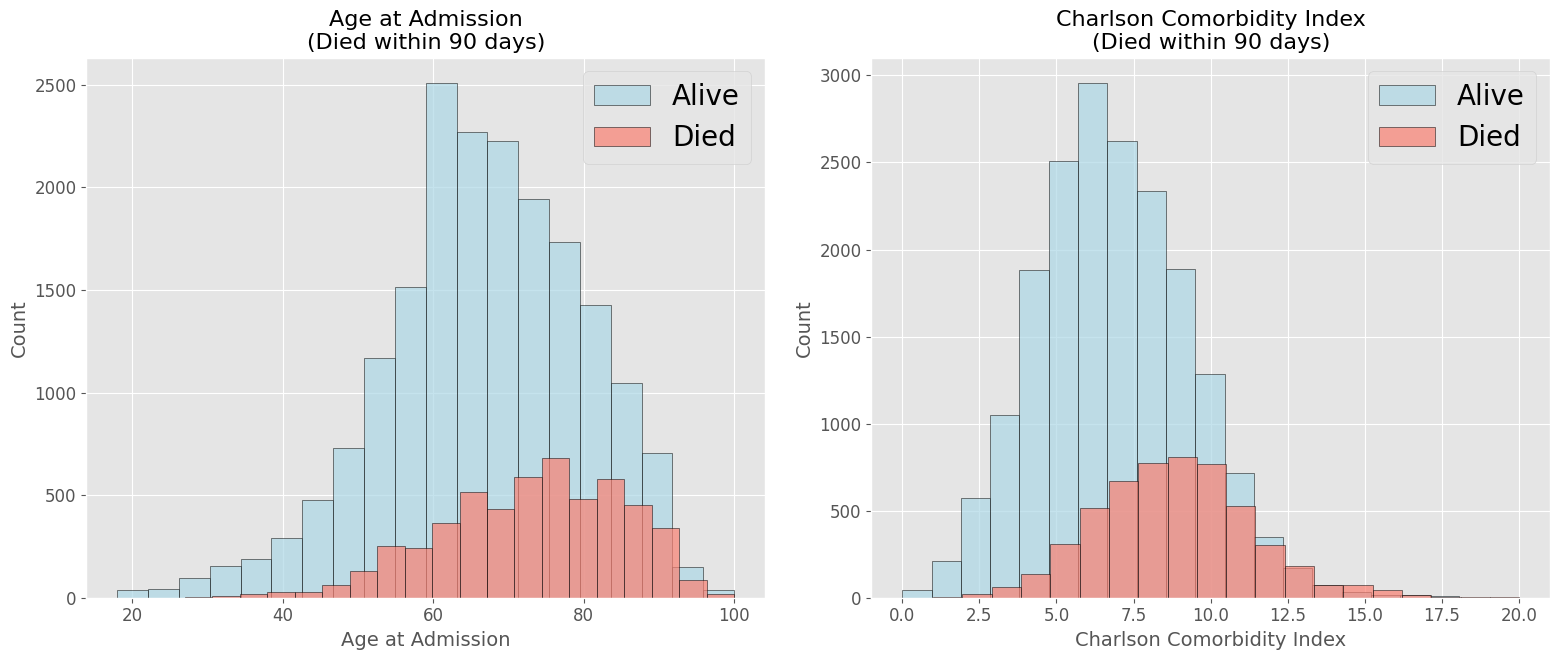

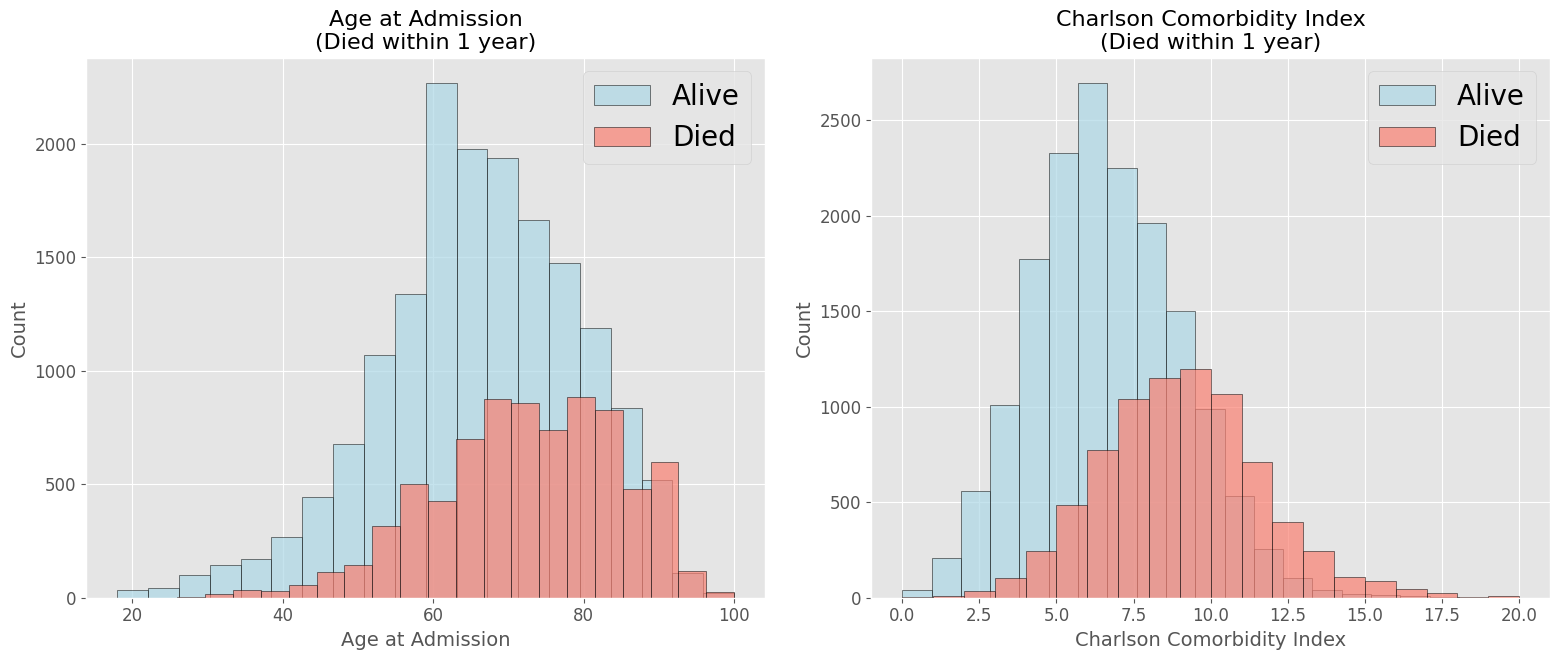

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
df.fillna({'died_within_30_days': False, 'died_within_90_days': False, 'died_within_1_year': False}, inplace=True)


# Recalculating avg_cci_by_age
avg_cci_by_age = df.groupby('age_at_admission')['charlson_comorbidity_index'].mean()

# Calculating average mortality rate by age
avg_mortality_by_age = df.groupby('age_at_admission')['died_within_1_year'].mean()

# Generating the enhanced plot with overlaid average mortality
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plotting Average CCI by Age
ax1.plot(avg_cci_by_age.index, avg_cci_by_age.values, marker='o', linestyle='-', color='dodgerblue', linewidth=2, markersize=6)
ax1.set_title('Average Charlson Comorbidity Index and 1 Year Mortality Rate by Age', fontsize=18)
ax1.set_xlabel('Age at Admission', fontsize=15)
ax1.set_ylabel('Average Charlson Comorbidity Index', fontsize=15, color='dodgerblue')
ax1.tick_params(axis='both', labelsize=13)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)

# Creating a second y-axis to plot average mortality rate by age
ax2 = ax1.twinx()
ax2.bar(avg_mortality_by_age.index, avg_mortality_by_age.values, color='salmon', alpha=0.6, width=0.4)
ax2.set_ylabel('Average Mortality Rate', fontsize=15, color='salmon')
ax2.tick_params(axis='y', labelsize=13)

plt.tight_layout()
plt.show()


# Redefining the time_frames list
time_frames = ['died_within_30_days', 'died_within_90_days', 'died_within_1_year']


# Adjusting for 'Alive' in death_status and handling NA values
df.fillna({'died_within_30_days': False, 'died_within_90_days': False, 'died_within_1_year': False}, inplace=True)

# Generating the enhanced plots again with the adjusted data
for frame in time_frames:
    alive = df[(df[frame] == False) | (df['death_status'] == 'Alive')]
    dead = df[df[frame] == True]

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))

    # Histogram for Age at Admission
    ax[0].hist(alive['age_at_admission'], bins=20, color='lightblue', label='Alive', alpha=0.7, edgecolor='black')
    ax[0].hist(dead['age_at_admission'], bins=20, color='salmon', label='Died', alpha=0.7, edgecolor='black')
    ax[0].set_title(f'Age at Admission\n({frame.replace("_", " ").capitalize()})', fontsize=16)
    ax[0].set_xlabel('Age at Admission', fontsize=14)
    ax[0].set_ylabel('Count', fontsize=14)
    ax[0].legend(frameon=True)
    ax[0].tick_params(axis='both', labelsize=12)

    # Histogram for Charlson Comorbidity Index
    ax[1].hist(alive['charlson_comorbidity_index'], bins=20, color='lightblue', label='Alive', alpha=0.7, edgecolor='black')
    ax[1].hist(dead['charlson_comorbidity_index'], bins=20, color='salmon', label='Died', alpha=0.7, edgecolor='black')
    ax[1].set_title(f'Charlson Comorbidity Index\n({frame.replace("_", " ").capitalize()})', fontsize=16)
    ax[1].set_xlabel('Charlson Comorbidity Index', fontsize=14)
    ax[1].set_ylabel('Count', fontsize=14)
    ax[1].legend(frameon=True)
    ax[1].tick_params(axis='both', labelsize=12)

    plt.tight_layout()
    plt.show()



The distribution shown on the histograms demonstrates the that CCI is more suitable in predicting long term mortality even when compared to age.

In [ ]:
# df = run_query(""" WITH DiabeticPatients AS (
# SELECT ic.subject_id, ic.hadm_id, ic.admittime, ic.dischtime, p.anchor_age, p.anchor_year, p.gender, p.dod, (p.anchor_age + EXTRACT(YEAR FROM ic.admittime) - p.anchor_year) AS age_at_admission
#     FROM `physionet-data.mimiciv_hosp.admissions` AS ic
#     JOIN `physionet-data.mimiciv_hosp.patients` AS p ON ic.subject_id = p.subject_id
#     WHERE ic.subject_id IN (
#         SELECT subject_id
#         FROM `physionet-data.mimiciv_hosp.diagnoses_icd` AS d
#         JOIN (SELECT * FROM `physionet-data.mimiciv_hosp.d_icd_diagnoses` WHERE long_title LIKE '%diabetes%') AS title
#         ON d.icd_code = title.icd_code AND d.icd_version = title.icd_version
#     )
# )

vital_signs = run_query("""
-- This query pivots the vital signs for the first 24 hours of each patient's ICU stay.
-- Vital signs include heart rate, blood pressure, respiration rate, and temperature
WITH DiabeticPatients AS (
    SELECT DISTINCT ic.subject_id, ic.hadm_id, ic.admittime, ic.dischtime, p.anchor_age, p.anchor_year, p.gender, p.dod,
           (p.anchor_age + EXTRACT(YEAR FROM ic.admittime) - p.anchor_year) AS age_at_admission
    FROM `physionet-data.mimiciv_hosp.admissions` AS ic
    JOIN `physionet-data.mimiciv_hosp.patients` AS p ON ic.subject_id = p.subject_id
    WHERE ic.subject_id IN (
        SELECT DISTINCT subject_id
        FROM `physionet-data.mimiciv_hosp.diagnoses_icd` d
        WHERE
          d.icd_code in ('25000','25002', '25010','25012','25040','25042','25050','25052', '25060','25062','25070','25072','25090','25092') OR
          d.icd_code LIKE '%E11%'
    )
),
FirstMeasurements AS (
    SELECT ce.subject_id, ce.hadm_id, ce.stay_id, MIN(ce.charttime) AS first_measurement_time
    FROM `physionet-data.mimiciv_icu.chartevents` ce
    JOIN `physionet-data.mimiciv_icu.icustays` ie ON ce.stay_id = ie.stay_id
    WHERE ce.subject_id IN (SELECT subject_id FROM DiabeticPatients)
    GROUP BY ce.subject_id, ce.hadm_id, ce.stay_id
),
VitalSignsFiltered AS (
    SELECT ce.subject_id, ce.hadm_id, ce.stay_id, ce.charttime, ce.itemid, ce.valuenum, fm.first_measurement_time
    FROM `physionet-data.mimiciv_icu.chartevents` ce
    JOIN FirstMeasurements fm ON ce.subject_id = fm.subject_id AND ce.hadm_id = fm.hadm_id AND ce.stay_id = fm.stay_id
    WHERE ce.charttime BETWEEN fm.first_measurement_time AND DATETIME_ADD(fm.first_measurement_time, INTERVAL 1 DAY)
)

SELECT
    vsf.subject_id,
    vsf.hadm_id,
    vsf.stay_id,
    vsf.charttime,
    AVG(CASE WHEN vsf.itemid = 220045 AND vsf.valuenum > 0 AND vsf.valuenum < 300 THEN vsf.valuenum ELSE NULL END) AS heart_rate
 , AVG(case when itemid in (220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as sbp
  , AVG(case when itemid in (220180,220051) and valuenum > 0 and valuenum < 300 then valuenum else null end) as dbp
  , AVG(case when itemid in (220052,220181,225312) and valuenum > 0 and valuenum < 300 then valuenum else null end) as mbp
  , AVG(case when itemid = 220179 and valuenum > 0 and valuenum < 400 then valuenum else null end) as sbp_ni
  , AVG(case when itemid = 220180 and valuenum > 0 and valuenum < 300 then valuenum else null end) as dbp_ni
  , AVG(case when itemid = 220181 and valuenum > 0 and valuenum < 300 then valuenum else null end) as mbp_ni
  , AVG(case when itemid in (220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as resp_rate
  , ROUND(
      AVG(case when itemid in (223761) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8 -- converted to degC in valuenum call
              when itemid in (223762) and valuenum > 10 and valuenum < 50  then valuenum else null end)
    , 2) as temperature
  , MAX(CASE WHEN itemid = 224642 THEN valuenum ELSE NULL END) AS temperature_site
  , AVG(case when itemid in (220277) and valuenum > 0 and valuenum <= 100 then valuenum else null end) as spo2
  , AVG(case when itemid in (225664,220621,226537) and valuenum > 0 then valuenum else null end) as glucose
FROM VitalSignsFiltered vsf
WHERE vsf.itemid IN (
    -- List of itemids for the vital signs
    220045, -- Heart Rate
    225309, -- ART BP Systolic
    225310, -- ART BP Diastolic
    225312, -- ART BP Mean
    220050, -- Arterial Blood Pressure systolic
    220051, -- Arterial Blood Pressure diastolic
    220052, -- Arterial Blood Pressure mean
    220179, -- Non Invasive Blood Pressure systolic
    220180, -- Non Invasive Blood Pressure diastolic
    220181, -- Non Invasive Blood Pressure mean
    220210, -- Respiratory Rate
    224690, -- Respiratory Rate (Total)
    220277, -- SPO2, peripheral
    -- GLUCOSE, both lab and fingerstick
    225664, -- Glucose finger stick
    220621, -- Glucose (serum)
    226537, -- Glucose (whole blood)
    -- TEMPERATURE
    223762, -- "Temperature Celsius"
    223761,  -- "Temperature Fahrenheit"
    224642 -- Temperature Site
    -- 226329 -- Blood Temperature CCO (C)
)
GROUP BY vsf.subject_id, vsf.hadm_id, vsf.stay_id, vsf.charttime
ORDER BY vsf.hadm_id, vsf.charttime;


""")

In [ ]:
vital_signs

,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,mbp_ni,resp_rate,temperature,temperature_site,spo2,glucose
0,14046553,20000094,35605481,2150-03-02 15:19:00,107.0,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN
1,14046553,20000094,35605481,2150-03-02 15:21:00,NaN,89.0,41.0,56.0,89.0,41.0,56.0,NaN,NaN,NaN,NaN,NaN
2,14046553,20000094,35605481,2150-03-02 15:27:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
3,14046553,20000094,35605481,2150-03-02 15:28:00,106.0,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN
4,14046553,20000094,35605481,2150-03-02 15:30:00,110.0,NaN,NaN,NaN,NaN,NaN,NaN,25.0,36.39,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919727,16572164,29999828,31355796,2180-10-29 04:00:00,83.0,138.0,79.0,87.0,138.0,79.0,87.0,13.0,36.67,NaN,95.0,NaN
919728,16572164,29999828,31355796,2180-10-29 05:00:00,87.0,130.0,72.0,85.0,130.0,72.0,85.0,13.0,NaN,NaN,94.0,NaN
919729,16572164,29999828,31355796,2180-10-29 07:00:00,81.0,130.0,72.0,86.0,130.0,72.0,86.0,14.0,NaN,NaN,95.0,190.0
919730,16572164,29999828,31355796,2180-10-29 08:00:00,84.0,137.0,75.0,88.0,137.0,75.0,88.0,26.0,37.28,NaN,95.0,NaN


In [ ]:
from datetime import timedelta

# Function to aggregate measurements
def aggregate_measurements(df, period_prefix):
    aggregation_funcs = {
    'heart_rate': ['max', 'min', 'mean', 'std'],
    'sbp': ['max', 'min', 'mean', 'std'],
    'dbp': ['max', 'min', 'mean', 'std'],
    'mbp': ['max', 'min', 'mean', 'std'],
    'sbp_ni': ['max', 'min', 'mean', 'std'],
    'dbp_ni': ['max', 'min', 'mean', 'std'],
    'mbp_ni': ['max', 'min', 'mean', 'std'],
    'resp_rate': ['max', 'min', 'mean', 'std'],
    'temperature': ['max', 'min', 'mean', 'std'],
    'spo2': ['max', 'min', 'mean', 'std'],
    'glucose': ['max', 'min', 'mean', 'std']
    }
    aggregated_df = df.groupby('hadm_id').agg(aggregation_funcs)
    # Flatten MultiIndex columns
    aggregated_df.columns = [f'{period_prefix}_{col[0]}_{col[1]}' for col in aggregated_df.columns]
    return aggregated_df.reset_index()

# Determine the first and last measurement time for each hadm_id
first_measurement_time = vital_signs.groupby('hadm_id')['charttime'].min().rename('first_measurement_time')
last_measurement_time = vital_signs.groupby('hadm_id')['charttime'].max().rename('last_measurement_time')

# Merge these times back into the original DataFrame
vital_signs = vital_signs.merge(first_measurement_time, on='hadm_id')
vital_signs = vital_signs.merge(last_measurement_time, on='hadm_id')

# Filter the DataFrame for the first 24 hours since the first measurement
first_24_hours = vital_signs[(vital_signs['charttime'] >= vital_signs['first_measurement_time']) &
                             (vital_signs['charttime'] <= vital_signs['first_measurement_time'] + timedelta(hours=24))]

# Filter the DataFrame for the last 24 hours before the last measurement
last_24_hours = vital_signs[(vital_signs['charttime'] >= vital_signs['last_measurement_time'] - timedelta(hours=24)) &
                            (vital_signs['charttime'] <= vital_signs['last_measurement_time'])]

# Aggregate the 'before' and 'after' measurements separately
aggregated_before = aggregate_measurements(first_24_hours, 'first_24h')
aggregated_after = aggregate_measurements(last_24_hours, 'last_24h')

# Merge the aggregated before and after DataFrames
aggregated_vitals = aggregated_before.merge(aggregated_after, on='hadm_id')



In [ ]:
aggregated_vitals

,hadm_id,first_24h_heart_rate_max,first_24h_heart_rate_min,first_24h_heart_rate_mean,first_24h_heart_rate_std,first_24h_sbp_max,first_24h_sbp_min,first_24h_sbp_mean,first_24h_sbp_std,first_24h_dbp_max,...,last_24h_temperature_mean,last_24h_temperature_std,last_24h_spo2_max,last_24h_spo2_min,last_24h_spo2_mean,last_24h_spo2_std,last_24h_glucose_max,last_24h_glucose_min,last_24h_glucose_mean,last_24h_glucose_std
0,20000094,127.0,18.0,110.041667,24.305088,105.0,35.0,78.904762,16.753820,78.0,...,36.430000,0.614112,100.0,95.0,98.625000,1.454877,383.0,190.0,262.000000,105.418215
1,20000147,113.0,95.0,105.458333,5.158186,125.0,84.0,106.192308,9.806199,78.0,...,36.832857,0.250447,100.0,93.0,96.827586,2.465026,253.0,106.0,156.333333,39.867427
2,20000351,100.0,85.0,90.545455,5.145165,153.0,139.0,147.500000,5.972158,90.0,...,37.110000,NaN,100.0,92.0,96.909091,3.207945,353.0,114.0,176.166667,89.165950
3,20001395,103.0,69.0,84.100000,10.934735,145.0,107.0,126.736842,9.988005,89.0,...,36.732000,0.226870,97.0,89.0,93.100000,2.447340,95.0,95.0,95.000000,NaN
4,20001494,84.0,56.0,62.684211,7.630732,142.0,101.0,122.722222,9.868581,88.0,...,36.748333,0.224180,95.0,92.0,94.000000,1.206045,283.0,151.0,209.000000,63.271900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15562,29996630,98.0,58.0,80.050000,13.188865,135.0,78.0,106.852941,15.121994,64.0,...,36.794286,0.218010,99.0,88.0,93.518519,2.276475,197.0,137.0,170.166667,25.662554
15563,29997128,83.0,58.0,66.833333,5.997584,155.0,103.0,134.608696,16.538493,73.0,...,36.934000,0.199825,98.0,91.0,94.458333,1.768791,221.0,141.0,190.600000,34.911316
15564,29997616,105.0,67.0,85.120000,12.118581,154.0,111.0,136.173913,10.986157,100.0,...,36.614000,0.111265,100.0,92.0,95.916667,2.165273,178.0,162.0,170.000000,11.313708
15565,29997858,87.0,59.0,76.208333,7.824039,128.0,87.0,109.863636,9.657444,93.0,...,36.978000,0.408191,100.0,96.0,97.958333,1.160179,260.0,140.0,198.818182,42.885471


In [ ]:
# Save the DataFrame as a CSV file
aggregated_vitals.to_csv('aggregated_vitals.csv', index=False)


In [ ]:
loaded_vitals = pd.read_csv('aggregated_vitals.csv')
loaded_vitals

,hadm_id,first_24h_heart_rate_max,first_24h_heart_rate_min,first_24h_heart_rate_mean,first_24h_heart_rate_std,first_24h_sbp_max,first_24h_sbp_min,first_24h_sbp_mean,first_24h_sbp_std,first_24h_dbp_max,...,last_24h_temperature_mean,last_24h_temperature_std,last_24h_spo2_max,last_24h_spo2_min,last_24h_spo2_mean,last_24h_spo2_std,last_24h_glucose_max,last_24h_glucose_min,last_24h_glucose_mean,last_24h_glucose_std
0,20000094,127.0,18.0,110.041667,24.305088,105.0,35.0,78.904762,16.753820,78.0,...,36.430000,0.614112,100.0,95.0,98.625000,1.454877,383.0,190.0,262.000000,105.418215
1,20000147,113.0,95.0,105.458333,5.158186,125.0,84.0,106.192308,9.806199,78.0,...,36.832857,0.250447,100.0,93.0,96.827586,2.465026,253.0,106.0,156.333333,39.867427
2,20000351,100.0,85.0,90.545455,5.145165,153.0,139.0,147.500000,5.972158,90.0,...,37.110000,NaN,100.0,92.0,96.909091,3.207945,353.0,114.0,176.166667,89.165950
3,20001395,103.0,69.0,84.100000,10.934735,145.0,107.0,126.736842,9.988005,89.0,...,36.732000,0.226870,97.0,89.0,93.100000,2.447340,95.0,95.0,95.000000,NaN
4,20001494,84.0,56.0,62.684211,7.630732,142.0,101.0,122.722222,9.868581,88.0,...,36.748333,0.224180,95.0,92.0,94.000000,1.206045,283.0,151.0,209.000000,63.271900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15562,29996630,98.0,58.0,80.050000,13.188865,135.0,78.0,106.852941,15.121994,64.0,...,36.794286,0.218010,99.0,88.0,93.518519,2.276475,197.0,137.0,170.166667,25.662554
15563,29997128,83.0,58.0,66.833333,5.997584,155.0,103.0,134.608696,16.538493,73.0,...,36.934000,0.199825,98.0,91.0,94.458333,1.768791,221.0,141.0,190.600000,34.911316
15564,29997616,105.0,67.0,85.120000,12.118581,154.0,111.0,136.173913,10.986157,100.0,...,36.614000,0.111265,100.0,92.0,95.916667,2.165273,178.0,162.0,170.000000,11.313708
15565,29997858,87.0,59.0,76.208333,7.824039,128.0,87.0,109.863636,9.657444,93.0,...,36.978000,0.408191,100.0,96.0,97.958333,1.160179,260.0,140.0,198.818182,42.885471


In [ ]:
# Assuming df is your dataframe
vital_signs['charttime'] = pd.to_datetime(vital_signs['charttime'])

# Sort by charttime
vital_signs.sort_values(by='charttime', inplace=True)

# Calculate change in heart rate
vital_signs['heart_rate_change'] = vital_signs['heart_rate'].diff()

# Calculate aggregated statistics for blood pressure every 24 hours
aggregated_bp = vital_signs.groupby(['subject_id', pd.Grouper(key='charttime', freq='24H')])['sbp', 'dbp'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()

# Binning blood pressure
vital_signs['bp_category'] = pd.cut(df['sbp'], bins=[0, 120, 129, 139, 180, float('inf')],
                           labels=['normal', 'elevated', 'hypertension_stage1', 'hypertension_stage2', 'hypertensive_crisis'])

# Binary indicators for temperature site
temperature_sites = vital_signs['temperature_site'].unique()
for site in temperature_sites:
    vital_signs[f'temperature_site_{site}'] = (vital_signs['temperature_site'] == site).astype(int)

# Missing data indicators
for col in ['heart_rate', 'sbp', 'dbp', 'mbp', 'resp_rate', 'temperature', 'spo2', 'glucose']:
    vital_signs[f'{col}_missing'] = vital_signs[col].isnull().astype(int)

# Time features from charttime
vital_signs['hour_of_day'] = vital_signs['charttime'].dt.hour

# Now join the aggregated blood pressure data back to the original dataframe
vital_signs = vital_signs.merge(aggregated_bp, on=['subject_id', 'charttime'], how='left')


<ipython-input-74-06426483ac4e>:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  aggregated_bp = vital_signs.groupby(['subject_id', pd.Grouper(key='charttime', freq='24H')])['sbp', 'dbp'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
<ipython-input-74-06426483ac4e>:30: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (1 levels on the left, 2 on the right)
  vital_signs = vital_signs.merge(aggregated_bp, on=['subject_id', 'charttime'], how='left')
<ipython-input-74-06426483ac4e>:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  vital_signs = vital_signs.merge(aggregated_bp, on=['subject_id', 'charttime'], how='left')


In [ ]:
vital_signs

,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,dbp_ni,...,"(sbp, mean)","(sbp, median)","(sbp, std)","(sbp, min)","(sbp, max)","(dbp, mean)","(dbp, median)","(dbp, std)","(dbp, min)","(dbp, max)"
0,16006168,22277686,30927169,2110-01-21 06:33:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16006168,22277686,30927169,2110-01-21 07:25:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,16006168,22277686,30927169,2110-01-21 09:33:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16006168,22277686,30927169,2110-01-21 12:19:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,16006168,22277686,30927169,2110-01-21 13:30:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761688,14239401,21199923,35906940,2211-05-02 02:31:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
761689,14239401,21199923,35906940,2211-05-02 03:00:00,75.0,102.0,56.0,72.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
761690,14239401,21199923,35906940,2211-05-02 04:00:00,80.0,95.0,52.0,67.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
761691,14239401,21199923,35906940,2211-05-02 05:00:00,80.0,103.0,54.0,71.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Start Here
## Not use aggregate functions
Training of suboptimal section of the report

In [41]:
# Import libraries
from datetime import timedelta
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read the CSV file
df = pd.read_csv('mortality.csv')
df

,Unnamed: 0,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,...,avg_height,death_status,age_at_admission,died_within_30_days,died_within_90_days,died_within_1_year,days_in_icu,charlson_comorbidity_index,gender_F,gender_M
0,0,10000980,26913865,39765666,2189-06-27 08:54:00,77.0,150.0,77.0,92.0,150.0,...,NaN,Deceased,76,False,False,False,6,9,True,False
1,1,10002013,23581541,39060235,2160-05-18 10:26:00,80.0,134.0,75.0,94.0,104.0,...,157.0,Alive,57,False,NaN,NaN,5,8,True,False
2,2,10002443,21329021,35044219,2183-10-18 00:50:00,81.0,136.0,81.0,99.0,136.0,...,178.0,Alive,53,False,NaN,NaN,3,4,False,True
3,3,10002495,24982426,36753294,2141-05-22 20:23:00,115.0,160.0,78.0,94.0,160.0,...,170.0,Alive,81,False,NaN,NaN,7,7,False,True
4,4,10005817,20626031,32604416,2132-12-15 10:58:00,80.0,126.0,51.0,74.0,NaN,...,173.0,Deceased,66,False,False,False,8,8,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15417,15417,19997473,27787494,32134105,2173-09-17 15:08:00,68.0,112.0,88.0,93.0,112.0,...,157.0,Alive,82,False,NaN,NaN,21,9,True,False
15418,15418,19997473,27787494,32568753,2173-09-13 20:12:00,87.0,115.0,70.0,81.0,115.0,...,157.0,Alive,82,False,NaN,NaN,21,9,True,False
15419,15419,19998878,26489544,34403689,2132-09-30 22:30:00,83.0,116.0,77.0,86.0,116.0,...,183.0,Deceased,56,False,False,True,2,6,False,True
15420,15420,19998878,29356037,30532790,2132-08-18 15:00:00,116.0,156.0,72.0,92.0,156.0,...,NaN,Deceased,56,False,False,True,6,6,False,True


In [32]:
summary_stats = df.describe()

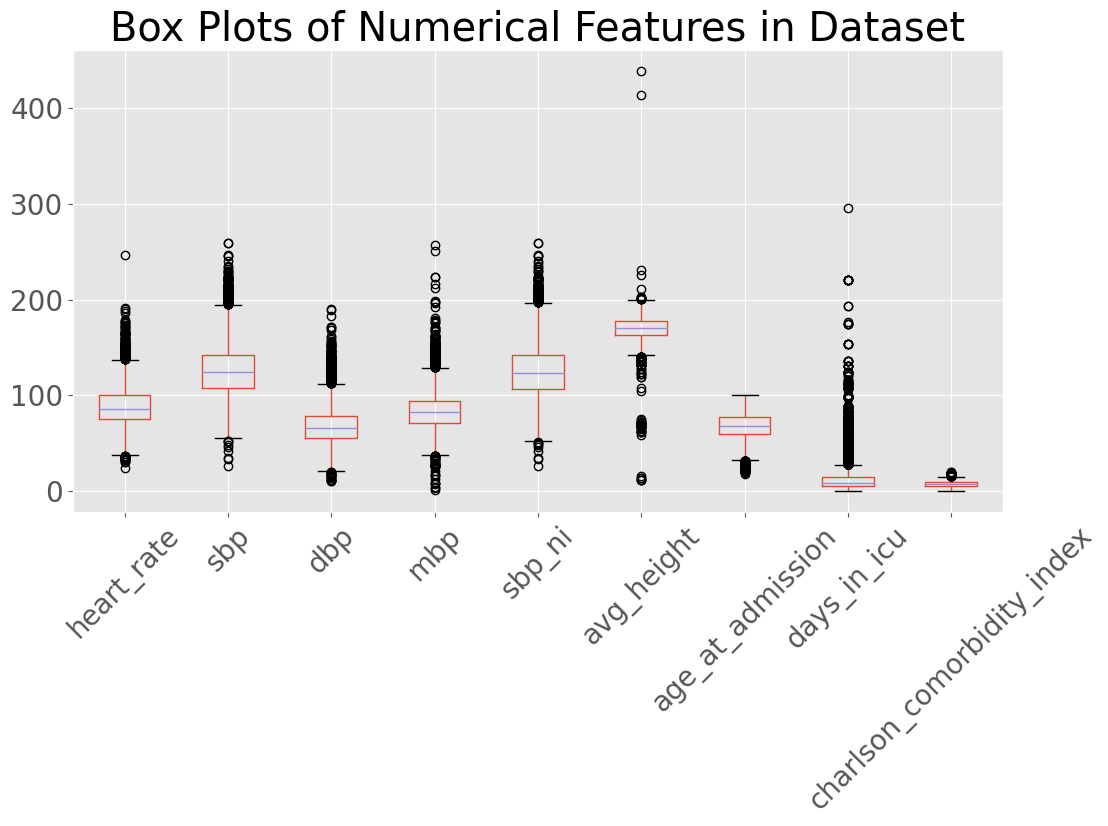

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Selecting only the numerical columns for plotting
numerical_cols = ['heart_rate', 'sbp', 'dbp', 'mbp', 'sbp_ni', 'avg_height', 'age_at_admission', 'days_in_icu', 'charlson_comorbidity_index']
numerical_data = df[numerical_cols]

# Plot box plots for each numerical feature
plt.figure(figsize=(12, 6))
numerical_data.boxplot()
plt.xticks(rotation=45)  # Rotate the feature names for better readability
plt.title('Box Plots of Numerical Features in Dataset')
plt.show()



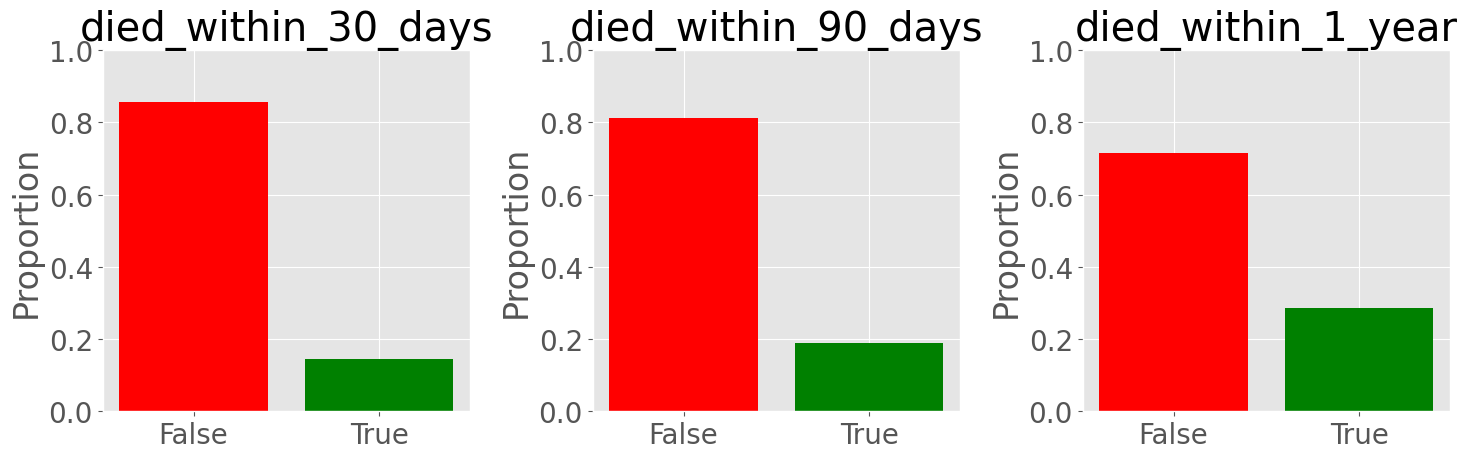

In [45]:
# Fill NaN values with False for the died_within columns
for column in ['died_within_30_days', 'died_within_90_days', 'died_within_1_year']:
    df[column] = df[column].fillna(False)

# Calculate the proportions
proportions = {
    column: df[column].value_counts(normalize=True).to_dict()
    for column in ['died_within_30_days', 'died_within_90_days', 'died_within_1_year']
}

# Plot the proportions
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for idx, (column, ax) in enumerate(zip(proportions, axes)):
    ax.bar(proportions[column].keys(), proportions[column].values(), color=['red', 'green'])
    ax.set_title(column)
    ax.set_ylim(0, 1)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['False', 'True'])
    ax.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

In [ ]:
df.isnull().sum()

Unnamed: 0                       0
subject_id                       0
hadm_id                          0
stay_id                          0
charttime                        0
heart_rate                       9
sbp                             85
dbp                             85
mbp                             35
sbp_ni                        1340
dbp_ni                        1341
mbp_ni                        1334
resp_rate                       24
temperature                    438
spo2                            26
glucose                        226
los                              0
avg_weight                      11
avg_height                    7123
death_status                     0
age_at_admission                 0
died_within_30_days              0
died_within_90_days           8506
died_within_1_year            8506
days_in_icu                      0
charlson_comorbidity_index       0
gender_F                         0
gender_M                         0
dtype: int64

In [11]:
# weight, height, died_within_days, bmi, gender, death_status, glucose

from sklearn.preprocessing import MinMaxScaler

# Replace NaN values in avg_weight and avg_height with their respective means
features_fill_nan = ['avg_weight', 'avg_height', 'glucose','heart_rate','sbp','dbp','mbp','sbp_ni','dbp_ni','mbp_ni','resp_rate','temperature','spo2','glucose','los']
for col in features_fill_nan:
    df[col].fillna(df[col].median(), inplace=True)

# Replace NaN values in died_within columns with False
columns_to_update = ['died_within_30_days', 'died_within_90_days', 'died_within_1_year']
for col in columns_to_update:
    df[col].fillna(False, inplace=True)

# Adding BMI Column
df['bmi'] = df['avg_weight'] / (df['avg_height'] / 100)**2

# Replace gender values: 'M' with 1 and 'F' with 0
df['gender_F'] = df['gender_F'].astype(str).str.strip().replace({'True': 1, 'False': 0})
df.drop(labels='gender_M',axis=1,inplace=True)

# Replace death_status values: 'Deceased' with 1 and 'Alive' with 0
df['death_status'] = df['death_status'].replace({'Deceased': 1, 'Alive': 0})

# Columns to normalize
cols_to_normalize = ['glucose','heart_rate','sbp','dbp','mbp','sbp_ni','dbp_ni','mbp_ni','resp_rate','temperature','spo2','los', 'avg_weight', 'avg_height', 'age_at_admission', 'days_in_icu', 'charlson_comorbidity_index', 'bmi']

# Instantiate the scaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform the columns
df[cols_to_normalize] = scaler.fit_transform(df[cols_to_normalize])


for col in columns_to_update:
    df[col] = df[col].astype(str).str.strip().replace({'True': 1, 'False': 0, '<NA>': np.nan})


df

,Unnamed: 0,subject_id,hadm_id,stay_id,charttime,heart_rate,sbp,dbp,mbp,sbp_ni,...,avg_height,death_status,age_at_admission,died_within_30_days,died_within_90_days,died_within_1_year,days_in_icu,charlson_comorbidity_index,gender_F,bmi
0,0,10000980,26913865,39765666,2189-06-27 08:54:00,0.237668,0.532189,0.372222,0.355469,0.532189,...,0.371495,1,0.707317,0,0,0,0.020270,0.45,1,0.002789
1,1,10002013,23581541,39060235,2160-05-18 10:26:00,0.251121,0.463519,0.361111,0.363281,0.334764,...,0.341121,0,0.475610,0,0,0,0.016892,0.40,1,0.004313
2,2,10002443,21329021,35044219,2183-10-18 00:50:00,0.255605,0.472103,0.394444,0.382812,0.472103,...,0.390187,0,0.426829,0,0,0,0.010135,0.20,0,0.005201
3,3,10002495,24982426,36753294,2141-05-22 20:23:00,0.408072,0.575107,0.377778,0.363281,0.575107,...,0.371495,0,0.768293,0,0,0,0.023649,0.35,0,0.002343
4,4,10005817,20626031,32604416,2132-12-15 10:58:00,0.251121,0.429185,0.227778,0.285156,0.416309,...,0.378505,1,0.585366,0,0,0,0.027027,0.40,0,0.003295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15417,15417,19997473,27787494,32134105,2173-09-17 15:08:00,0.197309,0.369099,0.433333,0.359375,0.369099,...,0.341121,0,0.780488,0,0,0,0.070946,0.45,1,0.002732
15418,15418,19997473,27787494,32568753,2173-09-13 20:12:00,0.282511,0.381974,0.333333,0.312500,0.381974,...,0.341121,0,0.780488,0,0,0,0.070946,0.45,1,0.002732
15419,15419,19998878,26489544,34403689,2132-09-30 22:30:00,0.264574,0.386266,0.372222,0.332031,0.386266,...,0.401869,1,0.463415,0,0,1,0.006757,0.30,0,0.002843
15420,15420,19998878,29356037,30532790,2132-08-18 15:00:00,0.412556,0.557940,0.344444,0.355469,0.557940,...,0.371495,1,0.463415,0,0,1,0.020270,0.30,0,0.003426


In [12]:
# df.drop(columns=['hadm_id','subject_id', 'stay_id','Unnamed: 0','charttime'], axis=1, inplace=True)
df.drop(columns=['hadm_id','subject_id', 'stay_id','Unnamed: 0','charttime', 'avg_weight', 'avg_height','sbp_ni','dbp_ni','mbp_ni','death_status'], axis=1, inplace=True)
df.describe()

,heart_rate,sbp,dbp,mbp,resp_rate,temperature,spo2,glucose,los,age_at_admission,died_within_30_days,died_within_90_days,died_within_1_year,days_in_icu,charlson_comorbidity_index,gender_F,bmi
count,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000,15422.000000
mean,0.288207,0.427798,0.321737,0.322933,0.260392,0.692621,0.961741,0.017408,0.033954,0.600167,0.145053,0.188821,0.284788,0.041782,0.363536,0.416613,0.003495
std,0.088918,0.111398,0.101441,0.073500,0.089774,0.048139,0.047253,0.012320,0.047879,0.161836,0.352165,0.391379,0.451328,0.050803,0.139352,0.493013,0.011310
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.228700,0.347639,0.250000,0.273438,0.194030,0.672402,0.936709,0.011314,0.010868,0.500000,0.000000,0.000000,0.000000,0.016892,0.250000,0.000000,0.002640
50%,0.278027,0.420601,0.311111,0.316406,0.238806,0.691672,0.974684,0.015218,0.019310,0.609756,0.000000,0.000000,0.000000,0.027027,0.350000,0.000000,0.003115
75%,0.340807,0.497854,0.377778,0.363281,0.313433,0.710943,1.000000,0.020725,0.036743,0.719512,0.000000,0.000000,1.000000,0.047297,0.450000,1.000000,0.003702
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define predictors and target
X = df.drop(columns=['died_within_30_days', 'died_within_90_days', 'died_within_1_year'])
y_30 = df['died_within_30_days']
y_90 = df['died_within_90_days']
y_year = df['died_within_1_year']

# Split data into training and test sets
X_train, X_test, y_30_train, y_30_test = train_test_split(X, y_30, test_size=0.2, random_state=42)
_, _, y_90_train, y_90_test = train_test_split(X, y_90, test_size=0.2, random_state=42)
_, _, y_year_train, y_year_test = train_test_split(X, y_year, test_size=0.2, random_state=42)

# Train a RandomForest classifier for each time frame
# max_depth 10 performs not well, 100 performs best
# n_estimator 100 performs best - 0.16, 50 and 500 both 0.14

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score


# Predicting Death within 30 Days

from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Baseline
dummy_clf = DummyClassifier(strategy="most_frequent").fit(X_train, y_30_train)
y_30_pred_dummy = dummy_clf.predict(X_test)

# Train RandomForest models with balanced data and updated hyperparameters
clf_30_rfc = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=100, n_estimators=100)
clf_90_rfc = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=100, n_estimators=100)
clf_year_rfc = RandomForestClassifier(random_state=42, class_weight='balanced', max_depth=100, n_estimators=100)


# Logistic Regression
clf_30_logreg = LogisticRegression(C=1, max_iter=1000, penalty='l2', solver='liblinear', random_state=42, class_weight='balanced').fit(X_train, y_30_train)
y_30_pred_logreg = clf_30_logreg.predict(X_test)

# SVM (with radial basis function kernel)
clf_30_svm = SVC(C=0.01, kernel='rbf',gamma='scale',class_weight='balanced', random_state=42).fit(X_train, y_30_train)
y_30_pred_svm = clf_30_svm.predict(X_test)

# # K-Nearest Neighbors (using 3 neighbors)
clf_30_knn = KNeighborsClassifier(n_neighbors=3, weights='distance').fit(X_train, y_30_train)
y_30_pred_knn = clf_30_knn.predict(X_test)

# # K-Nearest Neighbors (using 5 neighbors)
clf_30_knn_5 = KNeighborsClassifier(n_neighbors=5, weights='distance').fit(X_train, y_30_train)
y_30_pred_knn_5 = clf_30_knn_5.predict(X_test)

# # Gradient Boosting Classifier
clf_30_gb = GradientBoostingClassifier(random_state=42,n_estimators=1000,learning_rate=0.5,max_depth=1000).fit(X_train, y_30_train)
y_30_pred_gb = clf_30_gb.predict(X_test)

# Predicting Death within 90 Days

# Logistic Regression
clf_90_logreg = LogisticRegression(max_iter=1000).fit(X_train, y_90_train)
y_90_pred_logreg = clf_90_logreg.predict(X_test)

# SVM (with radial basis function kernel)
clf_90_svm = SVC(kernel='rbf').fit(X_train, y_90_train)
y_90_pred_svm = clf_90_svm.predict(X_test)

# K-Nearest Neighbors
clf_90_knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_90_train)
y_90_pred_knn = clf_90_knn.predict(X_test)

# K-Nearest Neighbors (using 5 neighbors)
clf_90_knn_5 = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_90_train)
y_90_pred_knn_5 = clf_90_knn_5.predict(X_test)

# Gradient Boosting Classifier
clf_90_gb = GradientBoostingClassifier().fit(X_train, y_90_train)
y_90_pred_gb = clf_90_gb.predict(X_test)

# Predicting Death within 1 Year

# Logistic Regression
clf_1y_logreg = LogisticRegression(max_iter=1000).fit(X_train, y_year_train)
y_1y_pred_logreg = clf_1y_logreg.predict(X_test)

# SVM (with radial basis function kernel)
clf_1y_svm = SVC(kernel='rbf').fit(X_train, y_year_train)
y_1y_pred_svm = clf_1y_svm.predict(X_test)

# K-Nearest Neighbors
clf_1y_knn = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_year_train)
y_1y_pred_knn = clf_1y_knn.predict(X_test)

# K-Nearest Neighbors (using 5 neighbors)
clf_1y_knn_5 = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_year_train)
y_1y_pred_knn_5 = clf_1y_knn_5.predict(X_test)

# Gradient Boosting Classifier
clf_1y_gb = GradientBoostingClassifier().fit(X_train, y_year_train)
y_1y_pred_gb = clf_1y_gb.predict(X_test)

# Train and evaluate the RandomForest models
clf_30_rfc.fit(X_train, y_30_train)
y_30_pred_rfc = clf_30_rfc.predict(X_test)
print("Random Forest - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_rfc))
print(classification_report(y_30_test, y_30_pred_rfc))
# balanced_acc_30_rfc = balanced_accuracy_score(y_30_test, y_30_pred_rfc)
# print("Balanced Accuracy - Random Forest - 30 Days Prediction:", balanced_acc_30_rfc)


clf_90_rfc.fit(X_train, y_90_train)
y_90_pred_rfc = clf_90_rfc.predict(X_test)
print("\nRandom Forest - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_rfc))
print(classification_report(y_90_test, y_90_pred_rfc))
# balanced_acc_90_rfc = balanced_accuracy_score(y_90_test, y_90_pred_rfc)
# print("Balanced Accuracy - Random Forest - 90 Days Prediction:", balanced_acc_90_rfc)

clf_year_rfc.fit(X_train, y_year_train)
y_year_pred_rfc = clf_year_rfc.predict(X_test)
print("\nRandom Forest - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_year_pred_rfc))
print(classification_report(y_year_test, y_year_pred_rfc))
# balanced_acc_year_rfc = balanced_accuracy_score(y_year_test, y_year_pred_rfc)
# print("Balanced Accuracy - Random Forest - 1 Year Prediction:", balanced_acc_year_rfc)





# Evaluate the models
print("Baseline - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_dummy))
print(classification_report(y_30_test, y_30_pred_dummy))

print("Logistic Regression - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_logreg))
print(classification_report(y_30_test, y_30_pred_logreg))

print("SVM - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_svm))
print(classification_report(y_30_test, y_30_pred_svm))

print("KNN - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_knn))
print(classification_report(y_30_test, y_30_pred_knn))

print("KNN-5 - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_knn_5))
print(classification_report(y_30_test, y_30_pred_knn_5))

print("Gradient Boosting - 30 Days Prediction:")
print(accuracy_score(y_30_test, y_30_pred_gb))
print(classification_report(y_30_test, y_30_pred_gb))

# Evaluating 90 days prediction models
print("Logistic Regression - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_logreg))
print(classification_report(y_90_test, y_90_pred_logreg))

print("SVM - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_svm))
print(classification_report(y_90_test, y_90_pred_svm))

print("KNN - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_knn))
print(classification_report(y_90_test, y_90_pred_knn))

print("KNN-5 - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_knn_5))
print(classification_report(y_90_test, y_90_pred_knn_5))

print("Gradient Boosting - 90 Days Prediction:")
print(accuracy_score(y_90_test, y_90_pred_gb))
print(classification_report(y_90_test, y_90_pred_gb))

# Evaluating 1 year prediction models
print("Logistic Regression - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_logreg))
print(classification_report(y_year_test, y_1y_pred_logreg))

print("SVM - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_svm))
print(classification_report(y_year_test, y_1y_pred_svm))

print("KNN - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_knn))
print(classification_report(y_year_test, y_1y_pred_knn))

print("KNN-5 - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_knn_5))
print(classification_report(y_year_test, y_1y_pred_knn_5))

print("Gradient Boosting - 1 Year Prediction:")
print(accuracy_score(y_year_test, y_1y_pred_gb))
print(classification_report(y_year_test, y_1y_pred_gb))

Random Forest - 30 Days Prediction:
0.8658022690437601
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      2655
           1       0.75      0.06      0.10       430

    accuracy                           0.87      3085
   macro avg       0.81      0.53      0.52      3085
weighted avg       0.85      0.87      0.81      3085


Random Forest - 90 Days Prediction:
0.8304700162074554
              precision    recall  f1-score   support

           0       0.84      0.99      0.90      2523
           1       0.69      0.13      0.21       562

    accuracy                           0.83      3085
   macro avg       0.76      0.56      0.56      3085
weighted avg       0.81      0.83      0.78      3085


Random Forest - 1 Year Prediction:
0.7724473257698541
              precision    recall  f1-score   support

           0       0.79      0.93      0.86      2243
           1       0.66      0.35      0.45       842

    accuracy    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
from sklearn.metrics import balanced_accuracy_score

# 30 Days Prediction Models
print("Balanced Accuracy - Baseline - 30 Days Prediction:", balanced_accuracy_score(y_30_test, y_30_pred_dummy))
print("Balanced Accuracy - Random Forest - 30 Days Prediction:", balanced_accuracy_score(y_30_test, y_30_pred_rfc))
print("Balanced Accuracy - Logistic Regression - 30 Days Prediction:", balanced_accuracy_score(y_30_test, y_30_pred_logreg))
print("Balanced Accuracy - SVM - 30 Days Prediction:", balanced_accuracy_score(y_30_test, y_30_pred_svm))
print("Balanced Accuracy - KNN - 30 Days Prediction:", balanced_accuracy_score(y_30_test, y_30_pred_knn))
print("Balanced Accuracy - KNN-5 - 30 Days Prediction:", balanced_accuracy_score(y_30_test, y_30_pred_knn_5))
print("Balanced Accuracy - Gradient Boosting - 30 Days Prediction:", balanced_accuracy_score(y_30_test, y_30_pred_gb))

# 90 Days Prediction Models
print("Balanced Accuracy - Logistic Regression - 90 Days Prediction:", balanced_accuracy_score(y_90_test, y_90_pred_logreg))
print("Balanced Accuracy - Random Forest - 90 Days Prediction:", balanced_accuracy_score(y_90_test, y_90_pred_rfc))
print("Balanced Accuracy - SVM - 90 Days Prediction:", balanced_accuracy_score(y_90_test, y_90_pred_svm))
print("Balanced Accuracy - KNN - 90 Days Prediction:", balanced_accuracy_score(y_90_test, y_90_pred_knn))
print("Balanced Accuracy - KNN-5 - 90 Days Prediction:", balanced_accuracy_score(y_90_test, y_90_pred_knn_5))
print("Balanced Accuracy - Gradient Boosting - 90 Days Prediction:", balanced_accuracy_score(y_90_test, y_90_pred_gb))

# 1 Year Prediction Models
print("Balanced Accuracy - Logistic Regression - 1 Year Prediction:", balanced_accuracy_score(y_year_test, y_1y_pred_logreg))
print("Balanced Accuracy - Random Forest - 1 Year Prediction:", balanced_accuracy_score(y_year_test, y_year_pred_rfc))
print("Balanced Accuracy - SVM - 1 Year Prediction:", balanced_accuracy_score(y_year_test, y_1y_pred_svm))
print("Balanced Accuracy - KNN - 1 Year Prediction:", balanced_accuracy_score(y_year_test, y_1y_pred_knn))
print("Balanced Accuracy - KNN-5 - 1 Year Prediction:", balanced_accuracy_score(y_year_test, y_1y_pred_knn_5))
print("Balanced Accuracy - Gradient Boosting - 1 Year Prediction:", balanced_accuracy_score(y_year_test, y_1y_pred_gb))


Balanced Accuracy - Baseline - 30 Days Prediction: 0.5
Balanced Accuracy - Random Forest - 30 Days Prediction: 0.5264003854070862
Balanced Accuracy - Logistic Regression - 30 Days Prediction: 0.7234069110497963
Balanced Accuracy - SVM - 30 Days Prediction: 0.6929641308632243
Balanced Accuracy - KNN - 30 Days Prediction: 0.5642666316296588
Balanced Accuracy - KNN-5 - 30 Days Prediction: 0.5476919371085709
Balanced Accuracy - Gradient Boosting - 30 Days Prediction: 0.6182652301493452
Balanced Accuracy - Logistic Regression - 90 Days Prediction: 0.5594777160444199
Balanced Accuracy - Random Forest - 90 Days Prediction: 0.5568256030286489
Balanced Accuracy - SVM - 90 Days Prediction: 0.5
Balanced Accuracy - KNN - 90 Days Prediction: 0.5766090755088771
Balanced Accuracy - KNN-5 - 90 Days Prediction: 0.5728860321342581
Balanced Accuracy - Gradient Boosting - 90 Days Prediction: 0.6259043137653164
Balanced Accuracy - Logistic Regression - 1 Year Prediction: 0.6381759880038504
Balanced Accurac

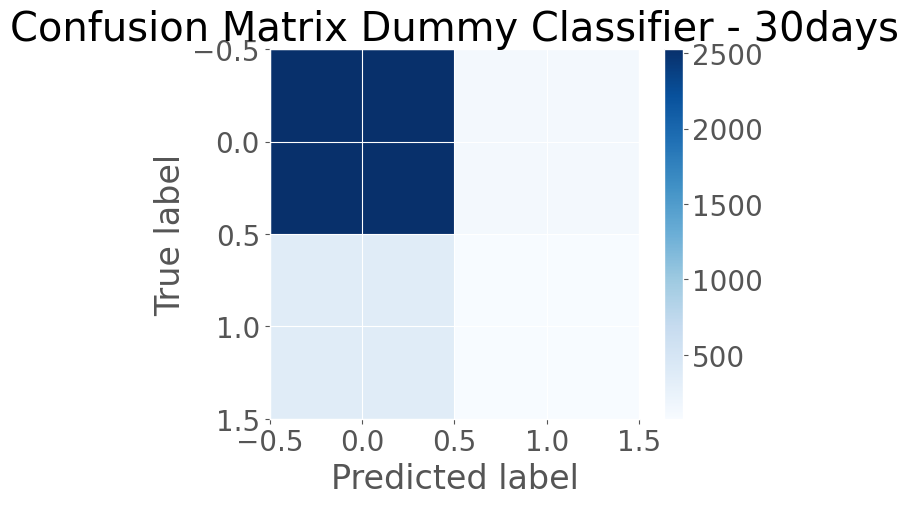

In [17]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Your data
y_test = y_30_test  # True labels
y_pred = y_30_pred_knn  # Predicted labels

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix Dummy Classifier - 30days')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

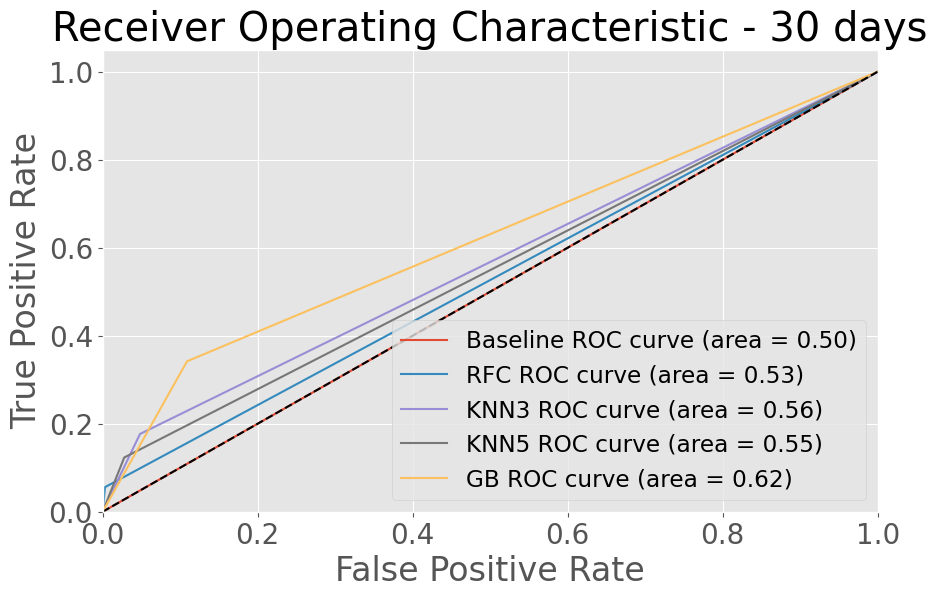

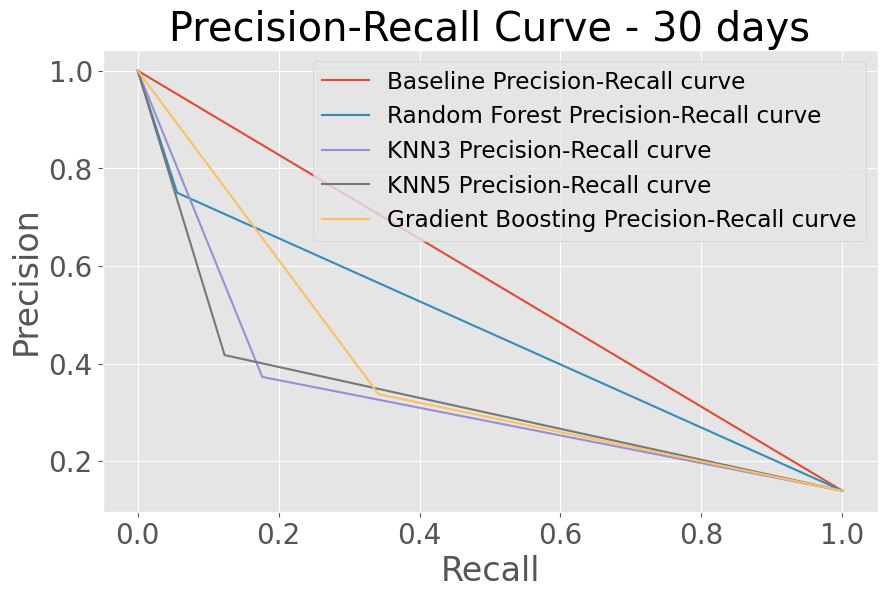

In [40]:
# Your data
y_test = y_30_test         # True labels
# y_pred1 = y_30_pred_dummy  # Predicted labels from Model 1
# y_pred2 = y_30_pred_logreg # Predicted labels from Model 2
# y_pred3 = y_30_pred_svm # Predicted labels from Model 3
y_pred1 = y_30_pred_dummy  # Predicted labels from Model 1
y_pred2 = y_30_pred_rfc # Predicted labels from Model 2
y_pred3 = y_30_pred_knn # Predicted labels from Model 3
y_pred4 = y_30_pred_knn_5 # Predicted labels from Model 3
y_pred5 = y_30_pred_gb # Predicted labels from Model 3

# ROC Curve for multiple models
fpr1, tpr1, _ = roc_curve(y_test, y_pred1)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
roc_auc2 = auc(fpr2, tpr2)

fpr3, tpr3, _ = roc_curve(y_test, y_pred3)
roc_auc3 = auc(fpr3, tpr3)

fpr4, tpr4, _ = roc_curve(y_test, y_pred4)
roc_auc4 = auc(fpr4, tpr4)

fpr5, tpr5, _ = roc_curve(y_test, y_pred5)
roc_auc5 = auc(fpr5, tpr5)

plt.figure(figsize=(10, 6))
plt.plot(fpr1, tpr1, label=f'Baseline ROC curve (area = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, label=f'RFC ROC curve (area = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, label=f'KNN3 ROC curve (area = {roc_auc3:.2f})')
plt.plot(fpr4, tpr4, label=f'KNN5 ROC curve (area = {roc_auc4:.2f})')
plt.plot(fpr5, tpr5, label=f'GB ROC curve (area = {roc_auc5:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - 30 days')
plt.legend(loc="lower right", fontsize='small')
plt.show()

# Precision-Recall Curve for multiple models
precision1, recall1, _ = precision_recall_curve(y_test, y_pred1)
precision2, recall2, _ = precision_recall_curve(y_test, y_pred2)
precision3, recall3, _ = precision_recall_curve(y_test, y_pred3)
precision4, recall4, _ = precision_recall_curve(y_test, y_pred4)
precision5, recall5, _ = precision_recall_curve(y_test, y_pred5)


plt.figure(figsize=(10, 6))
plt.plot(recall1, precision1, label='Baseline Precision-Recall curve')
plt.plot(recall2, precision2, label='Random Forest Precision-Recall curve')
plt.plot(recall3, precision3, label='KNN3 Precision-Recall curve')
plt.plot(recall4, precision4, label='KNN5 Precision-Recall curve')
plt.plot(recall5, precision5, label='Gradient Boosting Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - 30 days')
plt.legend(loc="upper right", fontsize='small')
plt.show()

## Deep Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import layers, regularizers
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report

mortality_df = pd.read_csv('mortality.csv')

# Drop non-feature columns
X = mortality_df.drop(columns=['subject_id', 'hadm_id', 'stay_id','death_status','charttime','died_within_30_days', 'died_within_90_days',
       'died_within_1_year'])
y = mortality_df['died_within_30_days'].astype(int)

# Handle missing values (simple imputation)
X.fillna(X.mean(), inplace=True)

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = Sequential([
    Dense(256, activation='relu',kernel_regularizer=regularizers.l1(0.01), input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    Dropout(0.2),
    Dense(128,kernel_regularizer=regularizers.l1(0.01), activation='relu'),
    layers.BatchNormalization(),
    Dense(128, activation='relu'),
    layers.BatchNormalization(),
    Dense(64, activation='relu'),
    layers.BatchNormalization(),
    Dense(32, activation='relu'),
    layers.BatchNormalization(),
    Dense(1, activation='sigmoid')  # Linear activation for regression
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=200,
    batch_size=64,
    callbacks=[early_stopping]
)
predictions = model.predict(X_test)
binary_predictions = (predictions > 0.18).astype(int)
print(classification_report(y_test, binary_predictions))